In [28]:
import gizmo_analysis as gizmo
import utilities as ut

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors

from astropy import units as u
from astropy import constants as cst

# from aqn import *
# from constants import *

from itertools import product
import scipy.stats as stats

import pickle

In [35]:
# FIRE's m12i data cube can be downloaded by running:
# wget -r -np https://users.flatironinstitute.org/~chayward/fire2_public_release/core_FIRE-2_runs/m12i_res7100/

# Import particle data

In [2]:
# // import FIRE m12i data cube
# simulation_directory = 'FIRE/m12i_res7100'
# part = gizmo.io.Read.read_snapshots('all', 'redshift', 0, simulation_directory)

# resave the imported and processed data as a file for quicker importing in the future:
# with open('part.pkl', 'wb') as file: pickle.dump(part, file)

# and open the saved file if there is one:
with open('../data/FIRE/part.pkl', 'rb') as file: part = pickle.load(file)
print(">> imported FIRE simulation data")

>> imported FIRE simulation data


# Define cube parameters

In [18]:
# define cube resolution parameters
cube_length       = 1.2   # kpc # 20 for radio
voxel_resolution  = 2**9 # bins / kpc
offset_x          = 0   # kpc  # 0 for radio
offset_y          = 8
print(f">> voxels per length: {voxel_resolution}")

voxel_length = cube_length / voxel_resolution * u.kpc
voxel_volume = voxel_length**3

# create bins based on defined resolution parameters
bins = np.linspace(-cube_length/2,cube_length/2,voxel_resolution+1)
# bin center coordinates will be used to identify voxels
bin_centers = (bins[1:] + bins[:-1])/2
voxel_centers = np.array([bin_centers, bin_centers, bin_centers]) # kpc

# create empty dictionaries for dark matter and gas components
dark_mat, neut_gas, ioni_gas = {}, {}, {}
dark_mat["name"], neut_gas["name"], ioni_gas["name"] = "Dark Matter", "Neutral Gas", "Ionized Gas"
dark_mat["short-name"], neut_gas["short-name"], ioni_gas["short-name"] = "dark_mat", "neut_gas", "ioni_gas"

>> voxels per length: 512


# Rotate and filter out particle ring

In [ ]:
# sort gas into neutral and ionized based on temperature
gas_temp = part['gas'].prop('temperature')
neutral_filter = gas_temp <  3e4
ionized_filter = gas_temp >= 3e4

# obtain coordinates of all particles within cube relative to Milky Way center
dark_mat["coords"] = part['dark'].prop('host.distance')
neut_gas["coords"] = part['gas'].prop('host.distance')[neutral_filter]
ioni_gas["coords"] = part['gas'].prop('host.distance')[ionized_filter]

for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["distances"] = np.sqrt(dictt["coords"][:,0]**2 + dictt["coords"][:,1]**2 + dictt["coords"][:,2]**2)
    dictt["rad_distances"] = np.sqrt(dictt["coords"][:,0]**2 + dictt["coords"][:,1]**2)

theta = np.radians(11)
cos_theta, sin_theta = np.cos(theta), np.sin(theta)
rotation_matrix = np.array([
    [1, 0, 0],
    [0, cos_theta, -sin_theta],
    [0, sin_theta, cos_theta]
])
for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["coords"] = dictt["coords"] @ rotation_matrix.T

# dark_mat["within_cube"] = np.where((dark_mat["coords"][:,0] < offset_x + cube_length/2) & 
#                                    (dark_mat["coords"][:,0] > offset_x - cube_length/2) &
#                                    (dark_mat["coords"][:,1] < offset_y + cube_length/2) & 
#                                    (dark_mat["coords"][:,1] > offset_y - cube_length/2) &
#                                    (np.abs(dark_mat["coords"][:,2]) < cube_length/2))
# neut_gas["within_cube"] = np.where((neut_gas["coords"][:,0] < offset_x + cube_length/2) & 
#                                    (neut_gas["coords"][:,0] > offset_x - cube_length/2) &
#                                    (neut_gas["coords"][:,1] < offset_y + cube_length/2) & 
#                                    (neut_gas["coords"][:,1] > offset_y - cube_length/2) &
#                                    (np.abs(neut_gas["coords"][:,2]) < cube_length/2))
# ioni_gas["within_cube"] = np.where((ioni_gas["coords"][:,0] < offset_x + cube_length/2) & 
#                                    (ioni_gas["coords"][:,0] > offset_x - cube_length/2) &
#                                    (ioni_gas["coords"][:,1] < offset_y + cube_length/2) & 
#                                    (ioni_gas["coords"][:,1] > offset_y - cube_length/2) &
#                                    (np.abs(ioni_gas["coords"][:,2]) < cube_length/2))

R_offset = 8
dark_mat["within_cube"] = np.where((dark_mat["distances"] < R_offset + cube_length) &
                                   (dark_mat["distances"] > R_offset - cube_length) &
                                   (np.abs(dark_mat["coords"][:,2])  < cube_length))
neut_gas["within_cube"] = np.where((neut_gas["distances"] < R_offset + cube_length) &
                                   (neut_gas["distances"] > R_offset - cube_length) &
                                   (np.abs(neut_gas["coords"][:,2])  < cube_length))
ioni_gas["within_cube"] = np.where((ioni_gas["distances"] < R_offset + cube_length) &
                                   (ioni_gas["distances"] > R_offset - cube_length) &
                                   (np.abs(ioni_gas["coords"][:,2])  < cube_length))

# obtain massses of all particles
dark_mat["masses"] = part['dark'].prop('mass')#[dark_mat["within_cube"]]
neut_gas["masses"] = part['gas'].prop('mass')[neutral_filter]#[neut_gas["within_cube"]]
ioni_gas["masses"] = part['gas'].prop('mass')[ionized_filter]#[ioni_gas["within_cube"]]

# obtain velocities of all particles
dark_mat["v"] = part['dark'].prop('velocity')[dark_mat["within_cube"]]
neut_gas["v"] = part['gas'].prop('velocity')[neutral_filter][neut_gas["within_cube"]]
ioni_gas["v"] = part['gas'].prop('velocity')[ionized_filter][ioni_gas["within_cube"]]

print(f">> obtained raw particle masses and velocities")

# Plot rings

In [ ]:
# for plotting the radial plot
# dark_mat["distances"] = np.sqrt(dark_mat["coords"][:,0]**2 + dark_mat["coords"][:,1]**2 + dark_mat["coords"][:,2]**2)
# neut_gas["distances"] = np.sqrt(neut_gas["coords"][:,0]**2 + neut_gas["coords"][:,1]**2 + neut_gas["coords"][:,2]**2)
# ioni_gas["distances"] = np.sqrt(ioni_gas["coords"][:,0]**2 + ioni_gas["coords"][:,1]**2 + ioni_gas["coords"][:,2]**2)




for dictt in [dark_mat, ioni_gas, neut_gas]:
    plt.figure(dpi=300)
    scat = plt.scatter(dictt["coords"][dictt["within_cube"]][:,0],
                dictt["coords"][dictt["within_cube"]][:,1], s=3, 
                       c=np.abs(dictt["coords"][dictt["within_cube"]][:,2]),
                       # c=dictt["masses"], 
                       cmap='autumn')
    plt.colorbar(scat, label='|z| [kpc]')
    plt.xlabel("x [kpc]",size=15)
    plt.ylabel("y [kpc]",size=15)
    plt.title(dictt["name"], size=16)
    plt.text(0.95, 0.05, str(len(dictt["masses"]))+" particles", 
         transform=plt.gca().transAxes, 
         fontsize=12, 
         verticalalignment='bottom', 
         horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.7))
    plt.xticks([-9.6, -8, -6.8])
    # plt.savefig("../visuals/Radio-particle-plot-"+"("+str(offset_x)+", "+str(offset_y)+")"+dictt["short-name"]+".svg", bbox_inches="tight")
    # plt.savefig("../visuals/Radio-particle-plot-"+"("+str(offset_x)+", "+str(offset_y)+")"+dictt["short-name"]+".png", bbox_inches="tight")
    # plt.savefig("../visuals/Radio-particle-plot-"+"radial-offset"+dictt["short-name"]+".svg", bbox_inches="tight")
    # plt.savefig("../visuals/Radio-particle-plot-"+"radial-offset"+dictt["short-name"]+".png", bbox_inches="tight")
    plt.show()


# Average density over entire ring

In [12]:
dictt["coords"].shape

(16157443, 3)

In [ ]:
V_inner = np.pi * (R_offset - cube_length)**2 * cube_length * u.kpc**3
V_outer = np.pi * (R_offset + cube_length)**2 * cube_length * u.kpc**3
V       = V_outer - V_inner

for dictt in [dark_mat, ioni_gas, neut_gas]:
    mass_within_cube = np.sum(dictt["masses"][dictt["within_cube"]]) * u.solMass
    dictt["total_avg_density"] = (mass_within_cube / V).to(u.kg / u.m**3)
    print(f'{dictt["name"]}: \t\t {dictt["total_avg_density"]}')

total_avg_temp = np.average(gas_temp[ionized_filter][ioni_gas["within_cube"]])
total_avg_temp
print(f'Ionized Gas temp: \t {grid_avg_temp} K')
print(f'Dv: \t\t\t 0.1c')
print(f'AQN Mass: \t\t 300g')

# Fit plane and optimize galaxy rotation

In [45]:
cube_length

20

In [121]:
def plot_gas():
    plt.figure(dpi=100, figsize=(5,5))
    
    plt.xlabel("y [kpc]",size=15)
    plt.ylabel("z [kpc]",size=15)
    bins = np.linspace(-10,10, 100)
    plt.hist2d(gas["y"],
                   gas["z"], bins=[bins, bins])
    plt.title("Binned gas masses", size=16)
    
    plt.show()

def plot_gas_2():
    plt.figure(dpi=100, figsize=(5,5))
    
    plt.xlabel("y [kpc]",size=15)
    plt.ylabel("z [kpc]",size=15)
    bins = np.linspace(-10,10, 100)
    plt.hist2d(gas["coords"][:,1],
                   gas["coords"][:,2], bins=[bins, bins])
    plt.title("Binned gas masses", size=16)
    
    plt.show()

In [120]:
gas = {}
gas["masses"] = part["gas"].prop("mass")
gas["coords"] = part['gas'].prop('host.distance')

gas["x"], gas["y"], gas["z"] = gas["coords"][:,0], gas["coords"][:,1], gas["coords"][:,2]
gas["r"] = np.sqrt(gas["x"]**2 + gas["y"]**2 + gas["z"]**2)

gas["region"] = np.where(gas["r"] < 5)  

for i in ["masses", "x", "y", "z", "r", "coords"]:
    gas[i] = gas[i][gas["region"]]

In [122]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# Assume gas is your dictionary with coordinates and masses
x = gas["x"]
y = gas["y"]
z = gas["z"]
masses = gas["masses"]

# Compute the square root of the masses for weighting
weights = np.sqrt(masses)

# Construct the weighted matrix A
A = np.vstack([x * weights, y * weights, weights]).T

# Apply weights to z as well
z_weighted = z * weights

# Solve for the coefficients a, b, c with weighted least squares
coefficients, residuals, _, _ = np.linalg.lstsq(A, z_weighted, rcond=None)

a, b, c = coefficients

# The normal vector to the plane
normal_vector = np.array([a, b, -1])
normal_vector /= np.linalg.norm(normal_vector)

# Calculate the axis of rotation (cross product with z-axis)
z_axis = np.array([0, 0, 1])
rotation_axis = np.cross(normal_vector, z_axis)
rotation_axis /= np.linalg.norm(rotation_axis)

# Calculate the angle of rotation
theta = np.arccos(np.dot(normal_vector, z_axis))

# Construct the rotation matrix
rotation = R.from_rotvec(rotation_axis * theta)
rotation_matrix = rotation.as_matrix()

# Apply the rotation to the galaxy coordinates
rotated_coordinates = rotation.apply(np.vstack([x, y, z]).T)

# Update the gas dictionary with the new rotated coordinates
gas["x"], gas["y"], gas["z"] = rotated_coordinates.T


In [123]:
np.vstack([x, y, z]).T.shape

(278310, 3)

In [126]:
# gas["coords"] = gas["coords"] @ rotation_matrix.T
gas["coords"] = rotation.apply(gas["coords"])

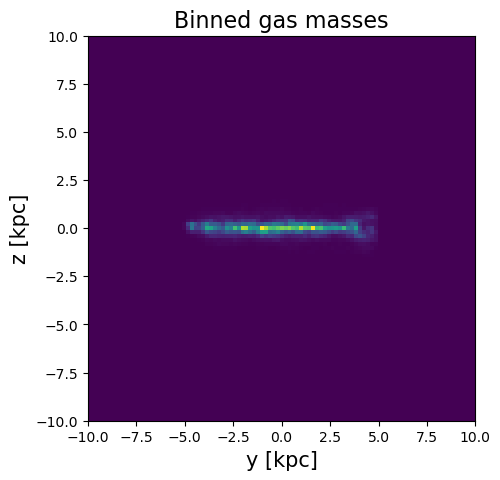

In [124]:
plot_gas()

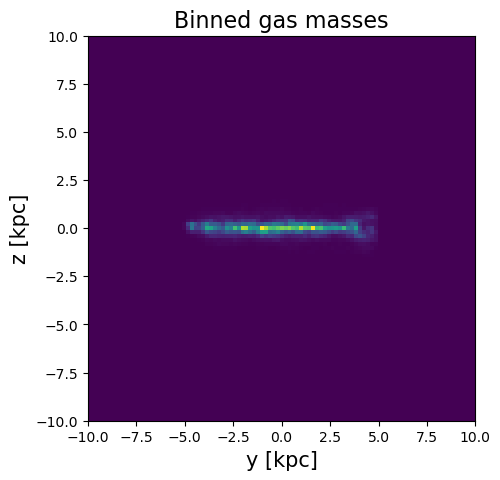

In [127]:
plot_gas_2()

# Rotation Demo

In [141]:
cube_length = 20

# sort gas into neutral and ionized based on temperature
gas_temp = part['gas'].prop('temperature')
neutral_filter = gas_temp <  3e4
ionized_filter = gas_temp >= 3e4

# obtain massses of all particles
dark_mat["masses"] = part['dark'].prop('mass')
neut_gas["masses"] = part['gas'].prop('mass')[neutral_filter]
ioni_gas["masses"] = part['gas'].prop('mass')[ionized_filter]

# obtain velocities of all particles
dark_mat["v"] = part['dark'].prop('velocity')
neut_gas["v"] = part['gas'].prop('velocity')[neutral_filter]
ioni_gas["v"] = part['gas'].prop('velocity')[ionized_filter]

# obtain coordinates of all particles within cube relative to Milky Way center
dark_mat["coords"] = part['dark'].prop('host.distance')
neut_gas["coords"] = part['gas'].prop('host.distance')[neutral_filter]
ioni_gas["coords"] = part['gas'].prop('host.distance')[ionized_filter]

# ############### Rotation 1 ####################
# theta = np.radians(11)  # Convert angle to radians
# cos_theta, sin_theta = np.cos(theta), np.sin(theta)
# rotation_matrix = np.array([
#     [1, 0, 0],
#     [0, cos_theta, -sin_theta],
#     [0, sin_theta, cos_theta]
# ])

# for dictt in [dark_mat, ioni_gas, neut_gas]:
#     dictt["coords"] = dictt["coords"] @ rotation_matrix.T
#     dictt["v"]      = dictt["v"]      @ rotation_matrix.T
# ###############################################

# ############### Rotation 2 ####################
# theta = np.radians(30)  # Convert angle to radians
# cos_theta, sin_theta = np.cos(theta), np.sin(theta)
# rotation_matrix = np.array([
#     [cos_theta, 0, -sin_theta],
#     [0, 1, 0],
#     [sin_theta, 0, cos_theta]
# ])

# for dictt in [dark_mat, ioni_gas, neut_gas]:
#     dictt["coords"] = dictt["coords"] @ rotation_matrix.T
#     dictt["v"]      = dictt["v"]      @ rotation_matrix.T
# ###############################################

for dictt in [dark_mat, ioni_gas, neut_gas]:
    # dictt["coords"] = dictt["coords"] @ rotation_matrix.T
    # dictt["v"]      = dictt["v"]      @ rotation_matrix.T
    
    dictt["coords"] = rotation.apply(dictt["coords"])
    dictt["v"]      = rotation.apply(dictt["v"])


for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["distances"] = np.sqrt(dictt["coords"][:,0]**2 + dictt["coords"][:,1]**2 + dictt["coords"][:,2]**2)
    dictt["rad_distances"] = np.sqrt(dictt["coords"][:,0]**2 + dictt["coords"][:,1]**2)

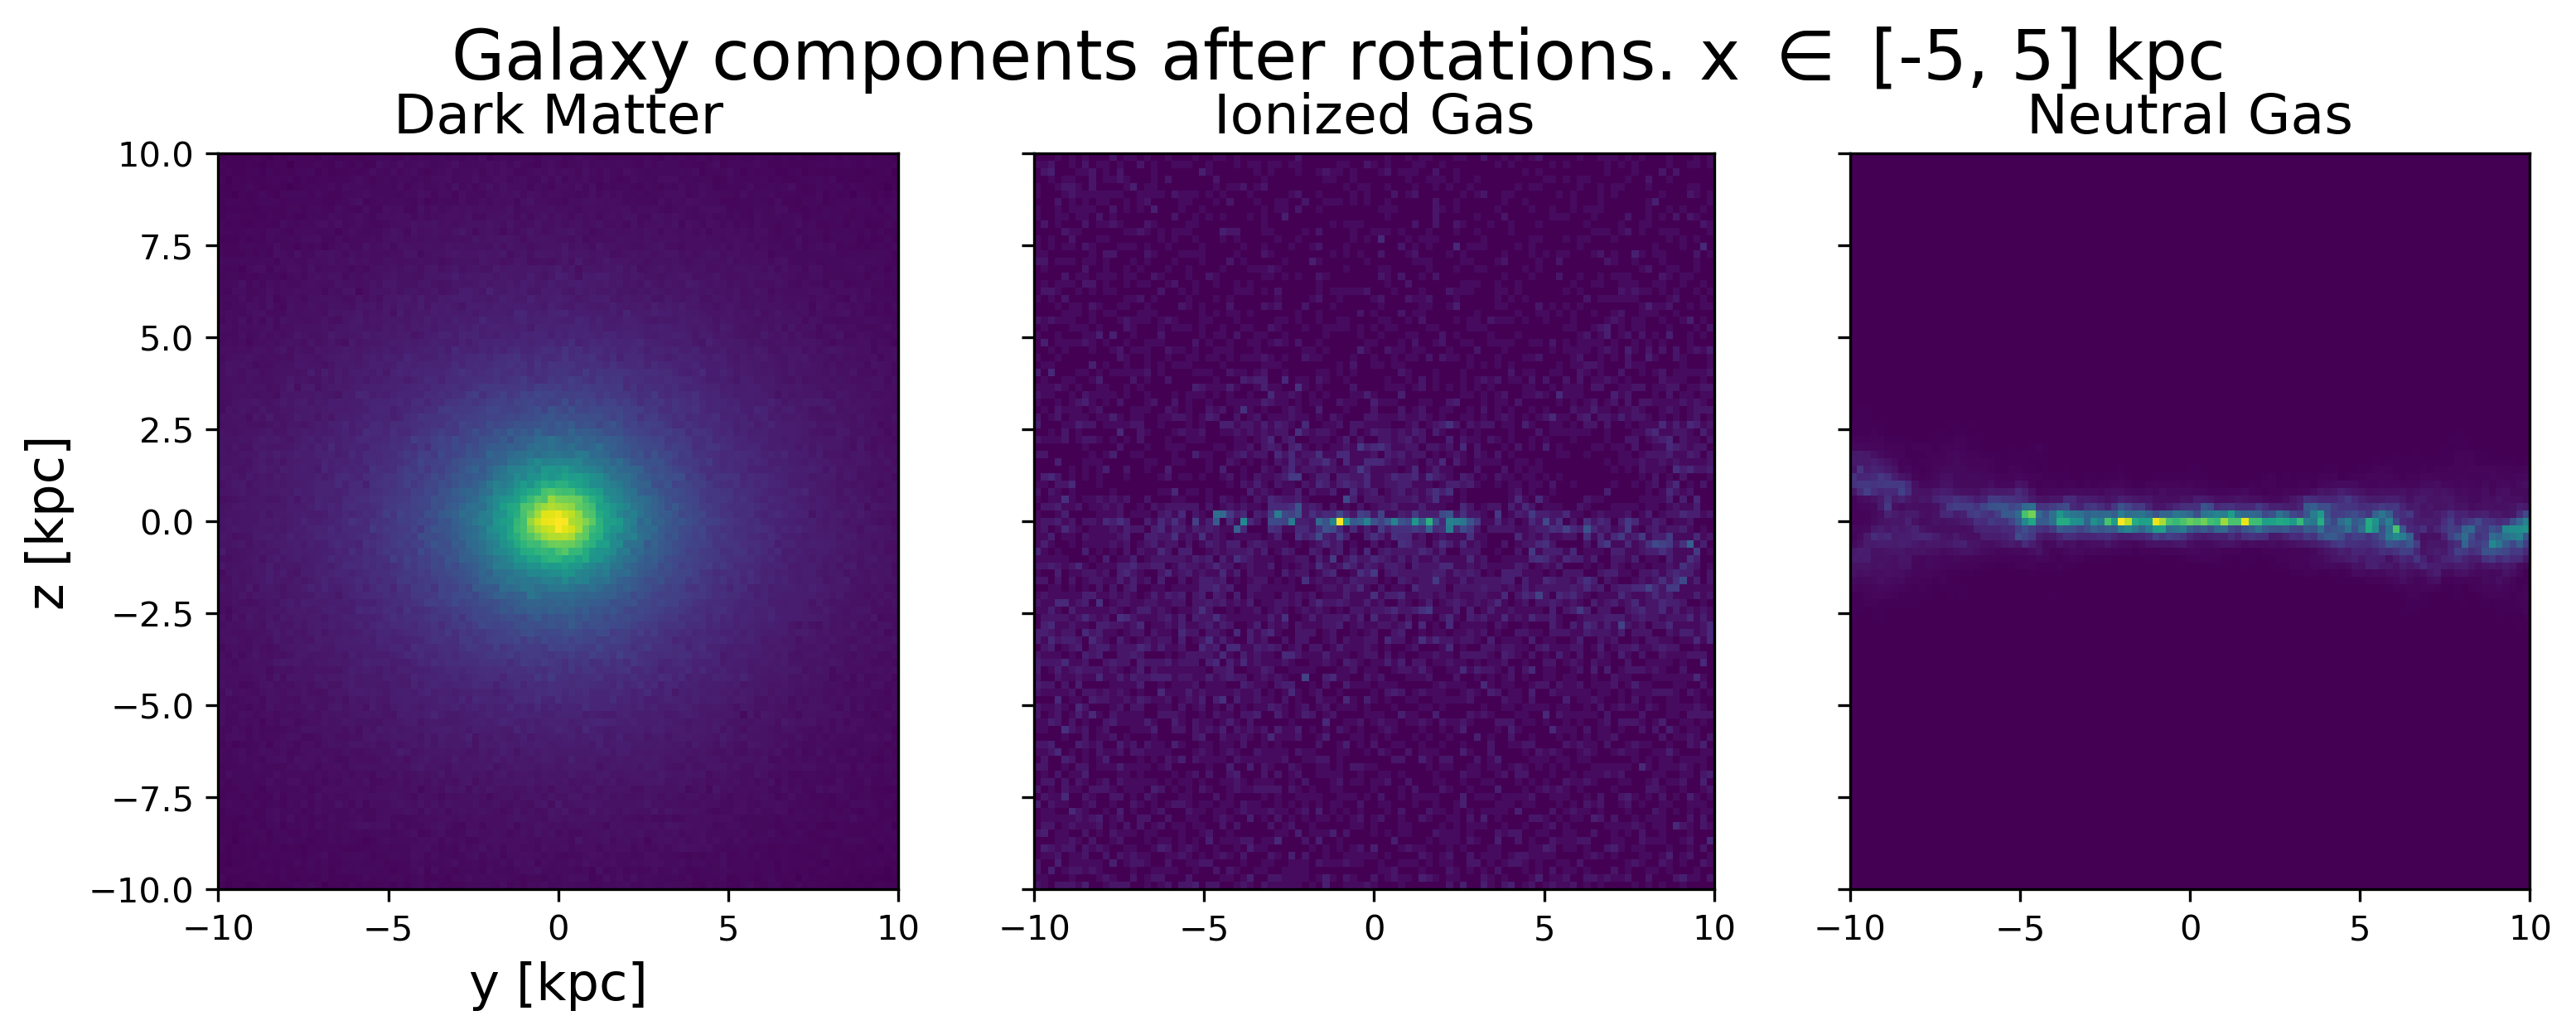

In [142]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["within_cube"] =    np.where((np.abs(dictt["coords"][:,0])  < 5) &
                                       (np.abs(dictt["coords"][:,1])  < cube_length/2) &
                                       (np.abs(dictt["coords"][:,2])  < cube_length/2))    

fig, axs = plt.subplots(1, 3, dpi=300, sharex = True, sharey = True, figsize=(12,4))

axs[0].set_xlabel("y [kpc]",size=15)
axs[0].set_ylabel("z [kpc]",size=15)
for i, dictt in enumerate([dark_mat, ioni_gas, neut_gas]):
    bins = np.linspace(-10,10, 100)
    axs[i].hist2d(dictt["coords"][dictt["within_cube"]][:,1],
                   dictt["coords"][dictt["within_cube"]][:,2], bins=[bins, bins])
    axs[i].set_title(dictt["name"], size=16)
    # axs[i].set_xticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])
    # axs[i].set_yticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])

fig.suptitle(r"Galaxy components after rotations. x $\in$ [-5, 5] kpc", size=20)
fig.subplots_adjust(top=0.85)
# plt.savefig("../visuals/densities-after-rotation.svg", bbox_inches="tight")
# plt.savefig("../visuals/densities-after-rotation.png", bbox_inches="tight")
plt.show()

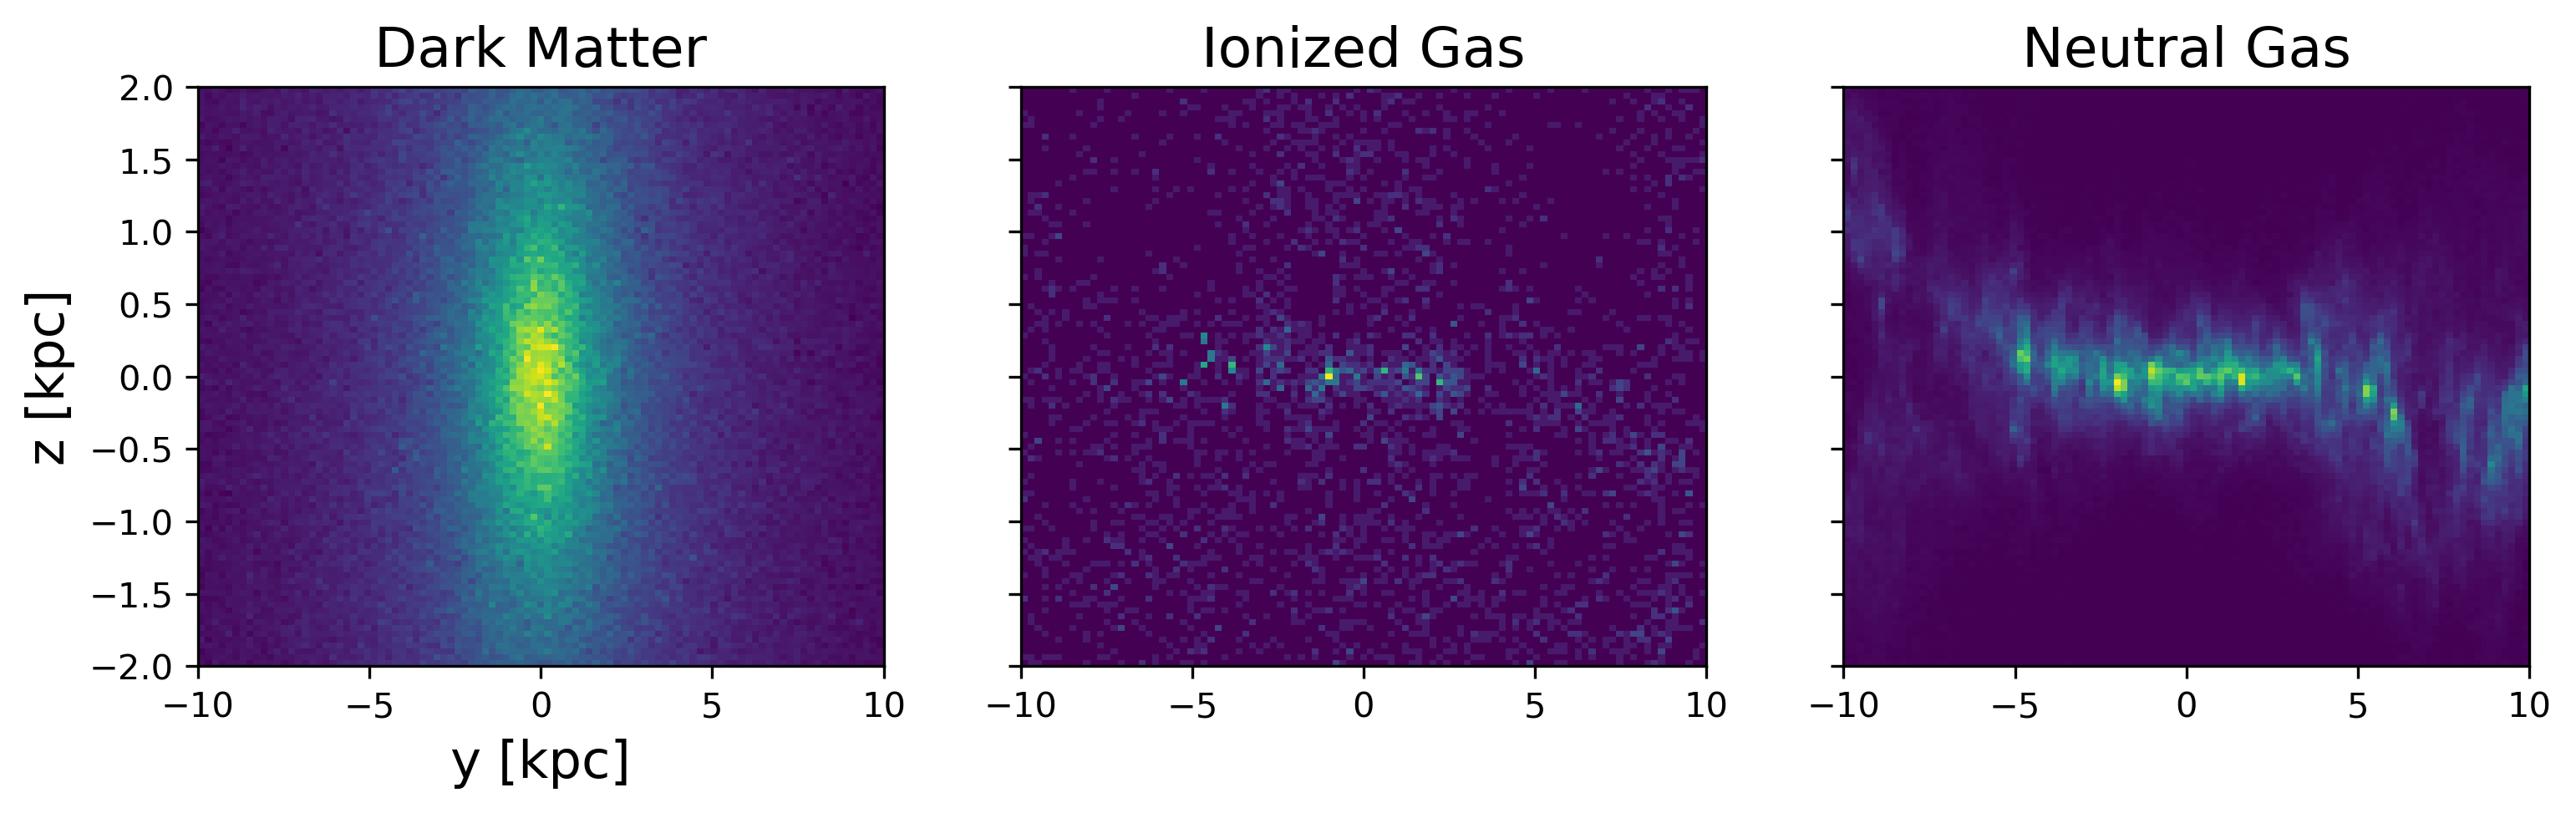

In [143]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["within_cube"] =    np.where((np.abs(dictt["coords"][:,0])  < 5) &
                                       (np.abs(dictt["coords"][:,1])  < cube_length/2) &
                                       (np.abs(dictt["coords"][:,2])  < cube_length/2))    

fig, axs = plt.subplots(1, 3, dpi=300, sharex = True, sharey = True, figsize=(12,3))

axs[0].set_xlabel("y [kpc]",size=15)
axs[0].set_ylabel("z [kpc]",size=15)
for i, dictt in enumerate([dark_mat, ioni_gas, neut_gas]):
    bins_z = np.linspace(-2,2, 100)
    bins_y = np.linspace(-10,10,100)
    axs[i].hist2d(dictt["coords"][dictt["within_cube"]][:,1],
                   dictt["coords"][dictt["within_cube"]][:,2], bins=[bins_y, bins_z])
    axs[i].set_title(dictt["name"], size=16)
    # axs[i].set_xticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])
    # axs[i].set_yticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])

# fig.suptitle(r"Galaxy components after rotations. x $\in$ [-5, 5] kpc", size=20)
# fig.subplots_adjust(top=0)
# plt.savefig("../visuals/densities-after-rotation.svg", bbox_inches="tight")
# plt.savefig("../visuals/densities-after-rotation.png", bbox_inches="tight")
plt.show()

In [9]:
num_points = 1000
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
x_coords = 8 * np.cos(angles)
y_coords = 8 * np.sin(angles)

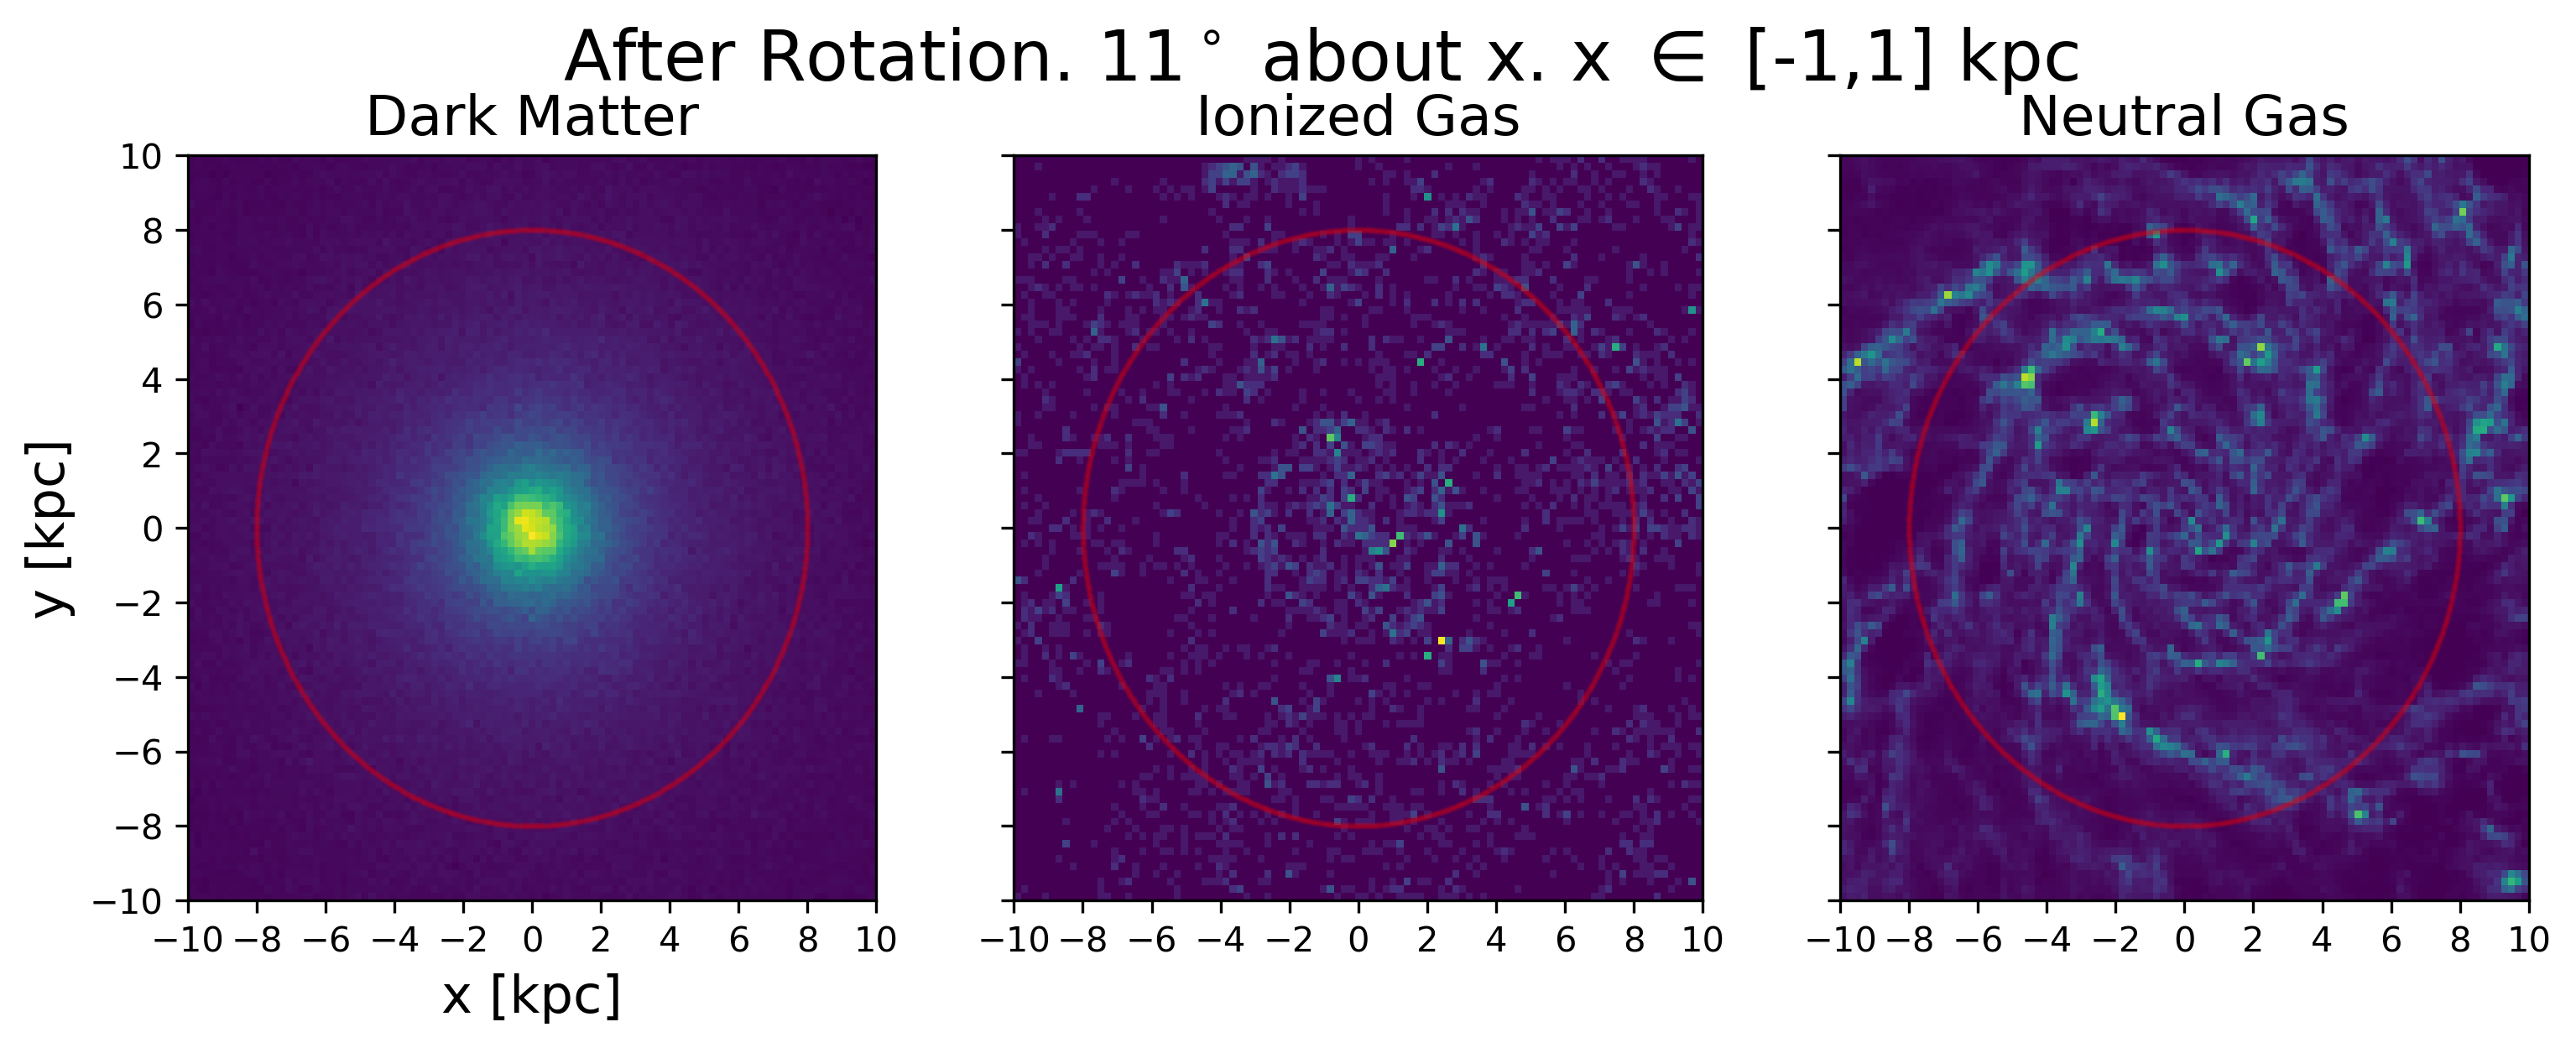

In [26]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["within_cube"] =    np.where((np.abs(dictt["coords"][:,0])  < cube_length/2) &
                                       (np.abs(dictt["coords"][:,1])  < cube_length/2) &
                                       (np.abs(dictt["coords"][:,2])  < 1.2))    

fig, axs = plt.subplots(1, 3, dpi=300, sharex = True, sharey = True, figsize=(12,4))

axs[0].set_xlabel("x [kpc]",size=15)
axs[0].set_ylabel("y [kpc]",size=15)
for i, dictt in enumerate([dark_mat, ioni_gas, neut_gas]):
    bins = np.linspace(-10,10, 100)
    axs[i].hist2d(dictt["coords"][dictt["within_cube"]][:,0],
                   dictt["coords"][dictt["within_cube"]][:,1], bins=[bins, bins])
    axs[i].scatter(x_coords, y_coords, s=1, c="red", alpha=0.1)
    axs[i].set_title(dictt["name"], size=16)
    axs[i].set_xticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])
    axs[i].set_yticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])
    
fig.suptitle(r"After Rotation. 11$^\circ$ about x. x $\in$ [-1,1] kpc", size=20)
fig.subplots_adjust(top=0.85)
plt.show()

# Count particles above and below z=0

In [ ]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["above"] =    np.where((np.abs(dictt["coords"][:,0])  < cube_length/2) &
                                 (np.abs(dictt["coords"][:,1])  < cube_length/2) &
                                 (np.abs(dictt["coords"][:,2])  < 1.2) &
                                 (np.abs(dictt["coords"][:,0])  > 6) &
                                 (np.abs(dictt["coords"][:,1])  > 6) &
                                 (dictt["coords"][:,2]  > 0))

    dictt["below"] =    np.where((np.abs(dictt["coords"][:,0])  < cube_length/2) &
                                 (np.abs(dictt["coords"][:,1])  < cube_length/2) &
                                 (np.abs(dictt["coords"][:,2])  < 1.2) &
                                 (np.abs(dictt["coords"][:,0])  > 6) &
                                 (np.abs(dictt["coords"][:,1])  > 6) &
                                 (dictt["coords"][:,2]  < 0))
    print(dictt["name"]+": ")
    print(dictt["masses"][dictt["above"]].shape, "\t", np.sum(dictt["masses"][dictt["above"]]))
    print(dictt["masses"][dictt["below"]].shape, "\t", np.sum(dictt["masses"][dictt["below"]]))
    print(dictt["masses"][dictt["above"]].shape[0]/dictt["masses"][dictt["below"]].shape[0],
         "\t",
         np.sum(dictt["masses"][dictt["above"]])/np.sum(dictt["masses"][dictt["below"]]))
    print("-----------------------")

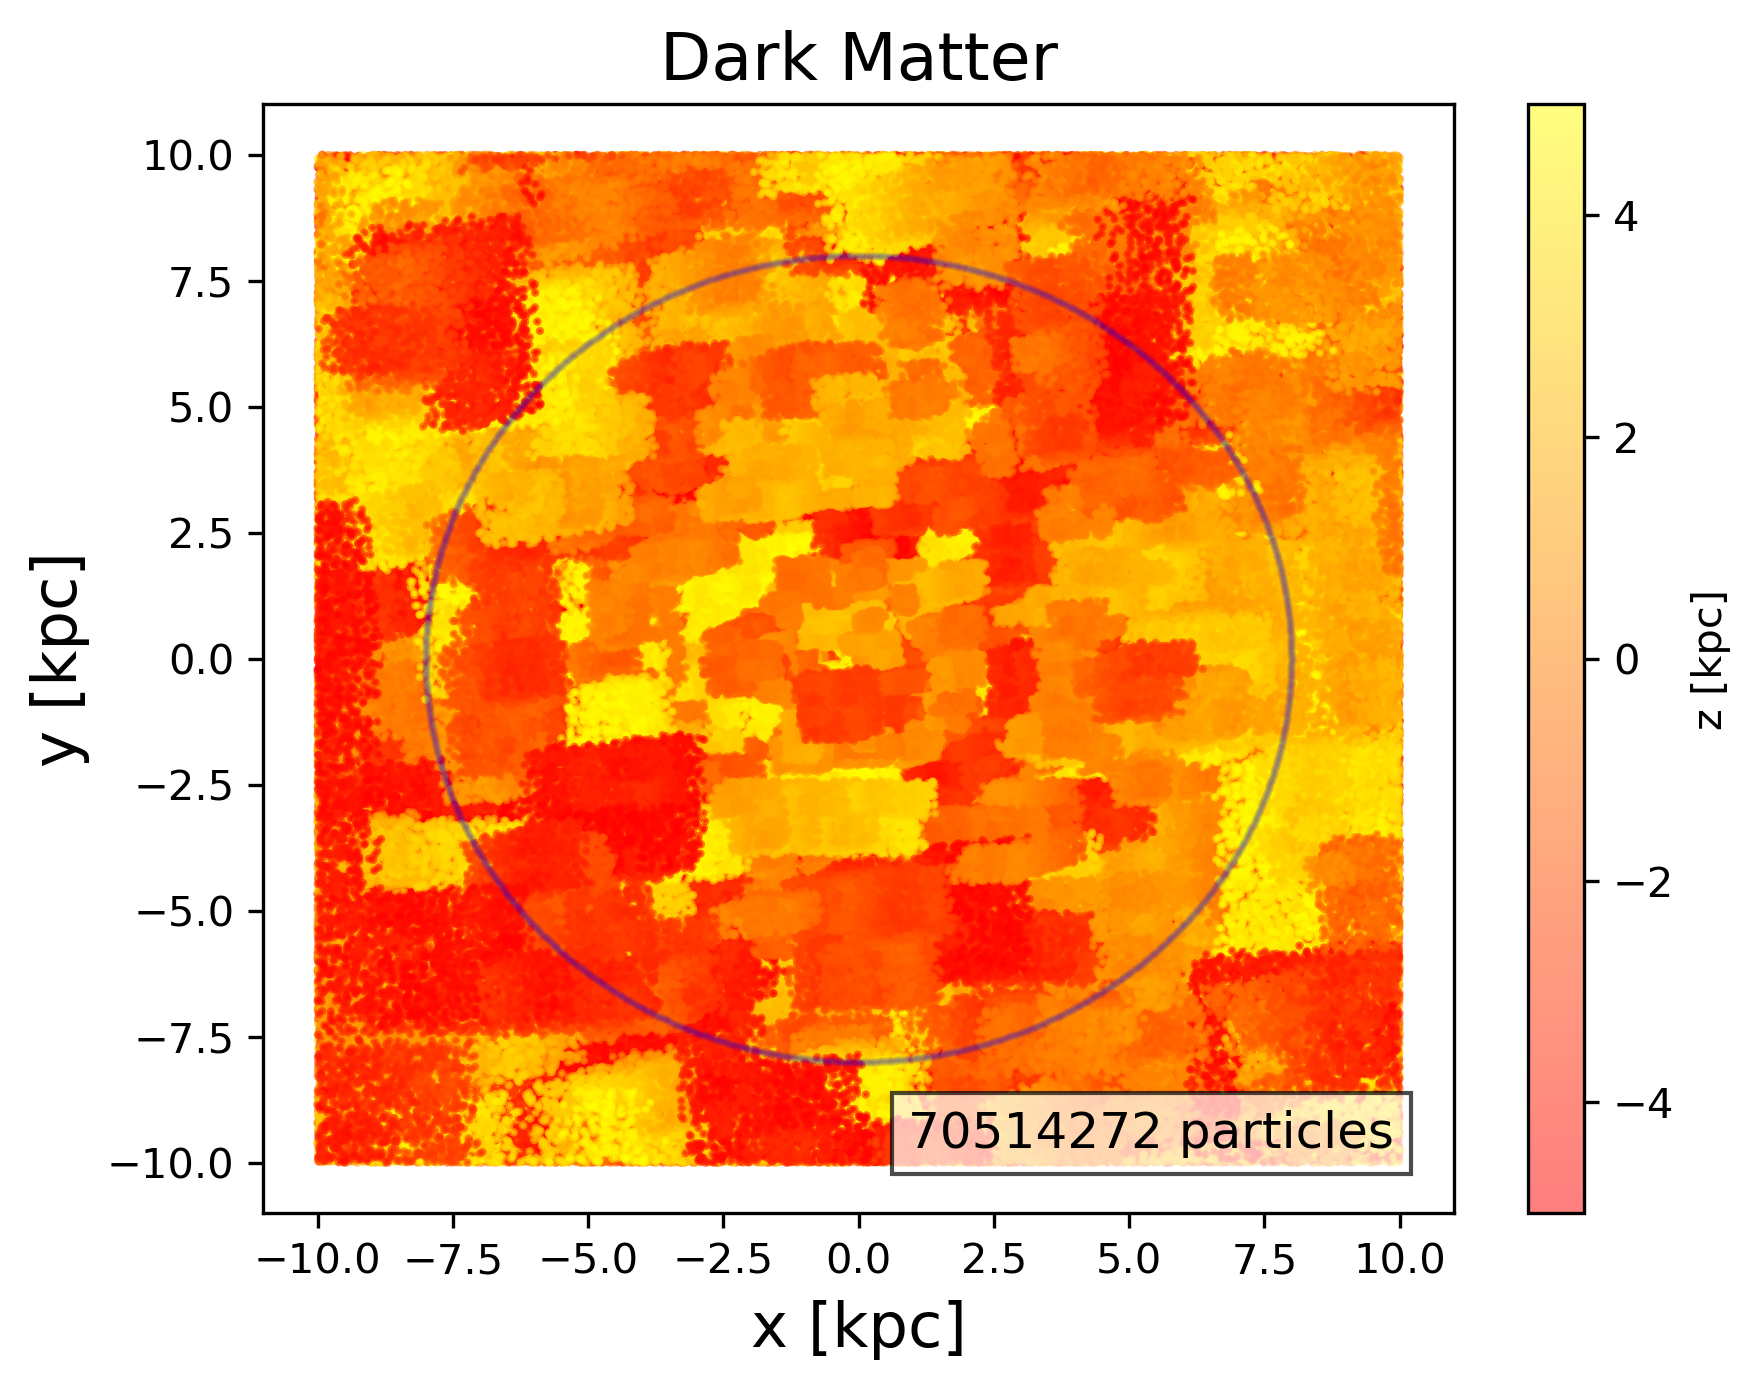

In [10]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["within_cube"] =    np.where((np.abs(dictt["coords"][:,0])  < cube_length/2) &
                                       (np.abs(dictt["coords"][:,1])  < cube_length/2) &
                                       (np.abs(dictt["coords"][:,2])  < 5))    

dictt = dark_mat

plt.figure(dpi=300)
scat = plt.scatter(dictt["coords"][dictt["within_cube"]][:,0],
                   dictt["coords"][dictt["within_cube"]][:,1], s=1, alpha=0.5,
                   c=dictt["coords"][dictt["within_cube"]][:,2],
                   cmap='autumn')
plt.colorbar(scat, label='z [kpc]')
plt.xlabel("x [kpc]",size=15)
plt.ylabel("y [kpc]",size=15)
plt.title(dictt["name"], size=16)
plt.text(0.95, 0.05, str(len(dictt["masses"]))+" particles", 
     transform=plt.gca().transAxes, 
     fontsize=12, 
     verticalalignment='bottom', 
     horizontalalignment='right',
     bbox=dict(facecolor='white', alpha=0.7))

plt.scatter(x_coords, y_coords, s=1, c="blue", alpha=0.1)

plt.savefig("../visuals/galaxy_tilted_demo.png", bbox_inches="tight")
plt.show()

In [ ]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["within_cube"] =    np.where((np.abs(dictt["coords"][:,0])  < cube_length/2) &
                                       (np.abs(dictt["coords"][:,1])  < 5) &
                                       (np.abs(dictt["coords"][:,2])  < cube_length/2))    

dictt = dark_mat

plt.figure(dpi=300)
scat = plt.scatter(dictt["coords"][dictt["within_cube"]][:,0],
                   dictt["coords"][dictt["within_cube"]][:,2], s=1, alpha=0.5,
                   c=dictt["coords"][dictt["within_cube"]][:,1],
                   cmap='autumn')
plt.colorbar(scat, label='y [kpc]')
plt.xlabel("x [kpc]",size=15)
plt.ylabel("z [kpc]",size=15)
plt.title(dictt["name"], size=16)
plt.text(0.95, 0.05, str(len(dictt["masses"]))+" particles", 
     transform=plt.gca().transAxes, 
     fontsize=12, 
     verticalalignment='bottom', 
     horizontalalignment='right',
     bbox=dict(facecolor='white', alpha=0.7))

plt.hlines([1.2, -1.2, 1.2, -1.2], [-9.2, -9.2, 6.8, 6.8], [-6.8,-6.8,9.2,9.2], color="blue", alpha=0.5)
plt.vlines([-9.2, -6.8, 6.8, 9.2], [-1.2, -1.2, -1.2, -1.2],  [1.2, 1.2, 1.2, 1.2], color="blue", alpha=0.5)

plt.show()

In [ ]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["within_cube"] =    np.where((np.abs(dictt["coords"][:,0])  < 5) &
                                       (np.abs(dictt["coords"][:,1])  < cube_length/2) &
                                       (np.abs(dictt["coords"][:,2])  < cube_length/2))    

plt.figure(dpi=300)
scat = plt.scatter(dictt["coords"][dictt["within_cube"]][:,1],
                   dictt["coords"][dictt["within_cube"]][:,2], s=1, alpha=0.5,
                   c=dictt["coords"][dictt["within_cube"]][:,0],
                   cmap='autumn')
plt.colorbar(scat, label='x [kpc]')
plt.xlabel("y [kpc]",size=15)
plt.ylabel("z [kpc]",size=15)
plt.title(dictt["name"], size=16)
plt.text(0.95, 0.05, str(len(dictt["masses"]))+" particles", 
     transform=plt.gca().transAxes, 
     fontsize=12, 
     verticalalignment='bottom', 
     horizontalalignment='right',
     bbox=dict(facecolor='white', alpha=0.7))

plt.hlines([1.2, -1.2, 1.2, -1.2], [-9.2, -9.2, 6.8, 6.8], [-6.8,-6.8,9.2,9.2], color="blue", alpha=0.5)
plt.vlines([-9.2, -6.8, 6.8, 9.2], [-1.2, -1.2, -1.2, -1.2],  [1.2, 1.2, 1.2, 1.2], color="blue", alpha=0.5)
plt.show()

In [ ]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["within_cube"] =    np.where((np.abs(dictt["coords"][:,0])  < cube_length/2) &
                                       (np.abs(dictt["coords"][:,1])  < 1) &
                                       (np.abs(dictt["coords"][:,2])  < 1) & 
                                       (np.abs(dictt["coords"][:,0])  > 6))    

fig, axs = plt.subplots(1, 3, dpi=300, sharex = True, sharey = True, figsize=(12,4))

axs[0].set_xlabel("x [kpc]",size=15)
axs[0].set_ylabel("z [kpc]",size=15)
for i, dictt in enumerate([dark_mat, ioni_gas, neut_gas]):
    bins = np.linspace(-10,10, 100)
    axs[i].hist2d(dictt["coords"][dictt["within_cube"]][:,0],
                   dictt["coords"][dictt["within_cube"]][:,2], bins=[bins, bins])
    axs[i].scatter(x_coords, y_coords, s=1, c="red", alpha=0.1)
    axs[i].set_title(dictt["name"], size=16)
    axs[i].set_xticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])
    axs[i].set_yticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])

fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["within_cube"] =    np.where((np.abs(dictt["coords"][:,0])  < 1) &
                                       (np.abs(dictt["coords"][:,1])  < cube_length/2) &
                                       (np.abs(dictt["coords"][:,2])  < 1) & 
                                       (np.abs(dictt["coords"][:,1])  > 6))    

fig, axs = plt.subplots(1, 3, dpi=300, sharex = True, sharey = True, figsize=(12,4))

axs[0].set_xlabel("x [kpc]",size=15)
axs[0].set_ylabel("z [kpc]",size=15)
for i, dictt in enumerate([dark_mat, ioni_gas, neut_gas]):
    bins = np.linspace(-10,10, 100)
    axs[i].hist2d(dictt["coords"][dictt["within_cube"]][:,1],
                   dictt["coords"][dictt["within_cube"]][:,2], bins=[bins, bins])
    axs[i].scatter(x_coords, y_coords, s=1, c="red", alpha=0.1)
    axs[i].set_title(dictt["name"], size=16)
    axs[i].set_xticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])
    axs[i].set_yticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])

fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    dictt["within_cube"] =    np.where((np.abs(dictt["coords"][:,0])  < 5) &
                                       (np.abs(dictt["coords"][:,1])  < cube_length/2) &
                                       (np.abs(dictt["coords"][:,2])  < cube_length/2))    

fig, axs = plt.subplots(1, 3, dpi=300, sharex = True, sharey = True, figsize=(12,4))

axs[0].set_xlabel("x [kpc]",size=15)
axs[0].set_ylabel("z [kpc]",size=15)
for i, dictt in enumerate([dark_mat, ioni_gas, neut_gas]):
    bins = np.linspace(-10,10, 100)
    axs[i].hist2d(dictt["coords"][dictt["within_cube"]][:,1],
                   dictt["coords"][dictt["within_cube"]][:,2], bins=[bins, bins])
    axs[i].scatter(x_coords, y_coords, s=1, c="red", alpha=0.1)
    axs[i].set_title(dictt["name"], size=16)
    axs[i].set_xticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])
    axs[i].set_yticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])

fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
S, Z = np.meshgrid(hist[1], hist[2])

bin_centers_s, bin_centers_z = np.meshgrid(bin_centers_s, bin_centers_z)

masses = hist[0]

masses

# Bin and average radially

In [15]:
def replace_max_with_second_largest(array):
    """
    Replaces the maximum element in a 29x29 array with the second largest element.
    
    Parameters:
    array (numpy.ndarray): The input 29x29 array.
    
    Returns:
    numpy.ndarray: The modified array with the maximum element replaced by the second largest element.
    """
    # if array.shape != (29, 29):
    #     raise ValueError("Input array must be of shape (29, 29)")

    # Step 1: Find the maximum element
    max_element = np.max(array)

    # Step 2: Find the second largest element
    unique_sorted_elements = np.unique(array)
    
    if len(unique_sorted_elements) < 2:
        raise ValueError("Array must contain at least two unique values")

    second_largest_element = unique_sorted_elements[-2]

    # Step 3: Replace the maximum element with the second largest element
    array[array == max_element] = second_largest_element

    return array

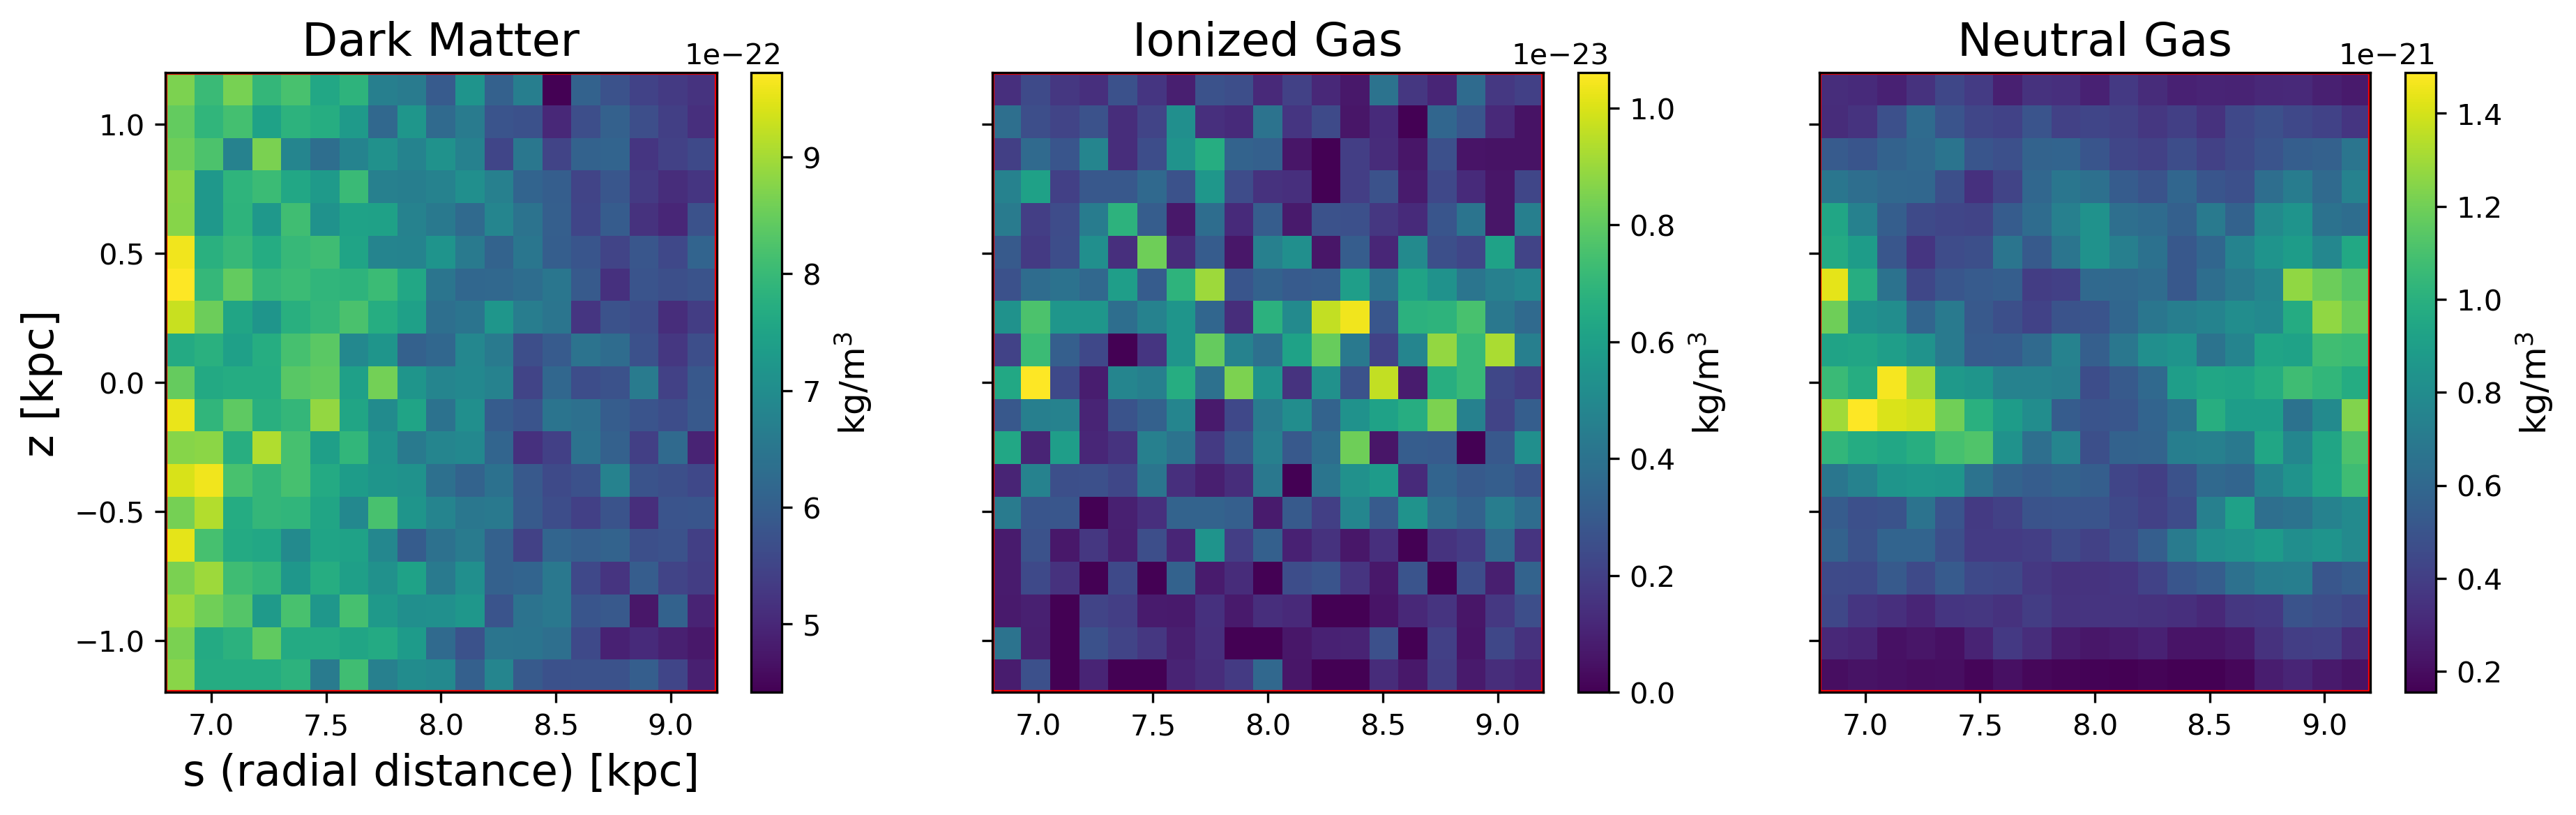

In [36]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    # dictt["within_cube"] =    np.where((np.abs(dictt["rad_distances"])  < 10) &
    #                                    (dictt["coords"][:,2] < 4    ) & 
    #                                    (dictt["coords"][:,2] > -4    ))  
    dictt["within_cube"] =    np.where((np.abs(dictt["rad_distances"])  < 9.2) &
                                       (np.abs(dictt["rad_distances"])  > 6.8) &
                                       (dictt["coords"][:,2] < 1.2    ) & 
                                       (dictt["coords"][:,2] > -1.2   ))  


fig, axs = plt.subplots(1, 3, dpi=300, sharex = True, sharey = True, figsize=(14,4))

axs[0].set_xlabel("s (radial distance) [kpc]",size=15)
axs[0].set_ylabel("z [kpc]",size=15)
for i, dictt in enumerate([dark_mat, ioni_gas, neut_gas]):
    # bins_s = np.linspace(0,10,50) 
    # bins_z = np.linspace(-4,4,50) 
    bins_s = np.linspace(6.8,9.2,20)
    bins_z = np.linspace(-1.2,1.2,20)

    hist = np.histogram2d(dictt["rad_distances"][dictt["within_cube"]],
                  dictt["coords"][dictt["within_cube"]][:,2], 
                 weights = dictt["masses"][dictt["within_cube"]],# cmap="OrRd",
                 bins=[bins_s, bins_z])

    # hist = np.histogram2d(dictt["rad_distances"][dictt["within_cube"]],
    #               dictt["coords"][dictt["within_cube"]][:,2], 
    #              weights = dictt["masses"][dictt["within_cube"]],
    #              bins=49, range=[[0,10],[-4,4]])

    S, Z = np.meshgrid(hist[1], hist[2])

    # bin_centers_s, bin_centers_z = np.meshgrid(bin_centers_s, bin_centers_z)
    
    masses = hist[0]
    
    # s_max, s_min = bins_s[1:].T, bins_s[:-1].T
    # delta_s_squared = s_max**2 - s_min**2
    # delta_z = bins_z[1] - bins_z[0]

    # density = (masses / (np.pi * delta_s_squared * delta_z) * u.solMass/u.kpc**3).to(u.kg/u.m**3)


    s_max, s_min = bins_s[1:].T, bins_s[:-1].T
    delta_s_squared = s_max**2 - s_min**2
    delta_s_squared = np.tile(delta_s_squared[:, np.newaxis], bins_z.shape[0]-1)
    delta_z = bins_z[1] - bins_z[0]
    
    density = (masses / (np.pi * delta_s_squared * delta_z) * u.solMass/u.kpc**3).to(u.kg/u.m**3)
    
    dictt["density"] = density
        
    c = axs[i].pcolormesh(S, Z, (density.value).T)

    axs[i].set_title(dictt["name"], size=16)
    axs[i].hlines([-1.2,1.2], [6.8, 6.8], [9.2,9.2], colors="red")
    axs[i].vlines([6.8,9.2], [-1.2, -1.2], [1.2,1.2], colors="red")
    cbar = fig.colorbar(c, ax=axs[i])
    cbar.set_label(r'kg/m$^3$', size=12)

# fig.suptitle(r"After Rotation. 11$^\circ$ about x. x $\in$ [-1,1] kpc", size=20)
fig.subplots_adjust(top=0.85, left=0.1)
plt.savefig("../visuals/z-s-plots-uv.png", bbox_inches="tight")
plt.show()

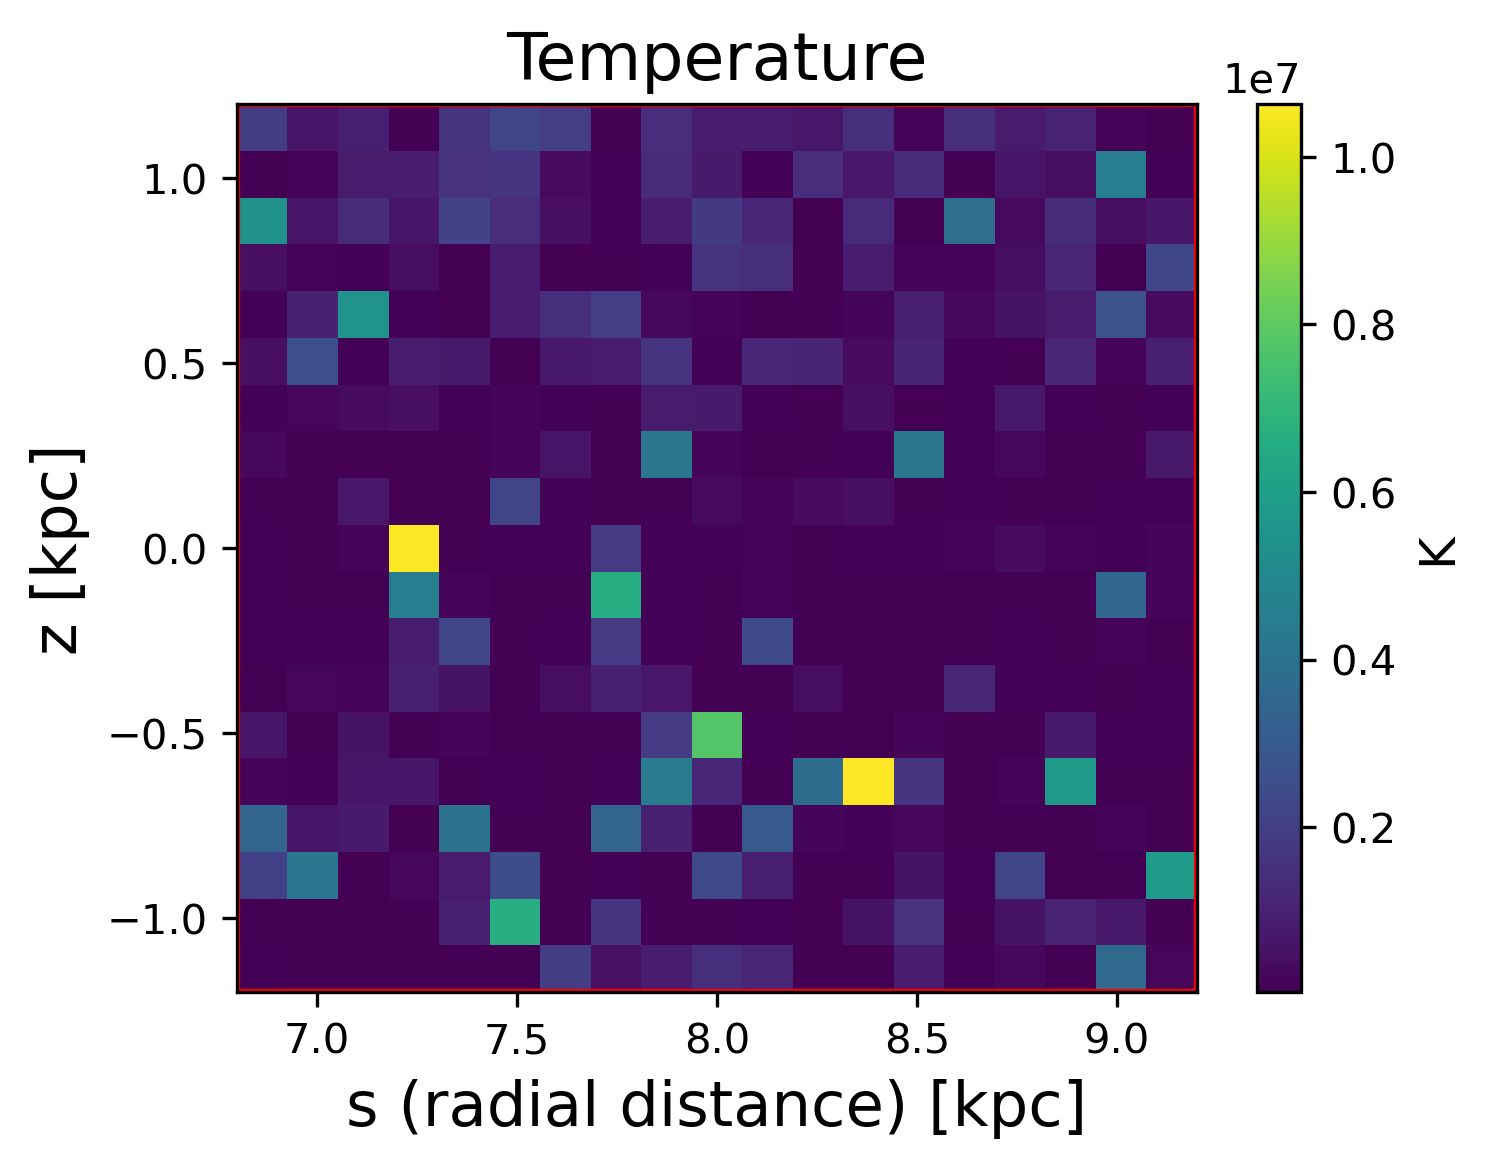

In [20]:
import scipy
fig, axs = plt.subplots(1, 1, dpi=300, sharex = True, sharey = True, figsize=(5,4))

axs.set_xlabel("s (radial distance) [kpc]",size=15)
axs.set_ylabel("z [kpc]",size=15)

bins_s = np.linspace(6.8,9.2,20)
bins_z = np.linspace(-1.2,1.2,20)
# bins_s = np.linspace(0,10,50) 
# bins_z = np.linspace(-4,4,50) 
# bin_centers_s = (bins_s[1:] + bins_s[:-1])/2
# bin_centers_z = (bins_z[1:] + bins_z[:-1])/2

# hist = np.histogram2d(ioni_gas["rad_distances"][dictt["within_cube"]],
#               ioni_gas["coords"][dictt["within_cube"]][:,2], 
#              weights = gas_temp[ionized_filter][dictt["within_cube"]],# cmap="OrRd",
#              bins=[bins_s, bins_z])

# S, Z = np.meshgrid(hist[1], hist[2])

# bin_centers_s, bin_centers_z = np.meshgrid(bin_centers_s, bin_centers_z)

res = scipy.stats.binned_statistic_2d(ioni_gas["rad_distances"][ioni_gas["within_cube"]],
                                  ioni_gas["coords"][ioni_gas["within_cube"]][:,2], 
                                gas_temp[ionized_filter][ioni_gas["within_cube"]], statistic='median', bins=[bins_s, bins_z])

S, Z = np.meshgrid(res[1], res[2])

res[0][np.isnan(res[0])] = np.min(res[0][np.logical_not(np.isnan(res[0]))])

# density =  ((masses / (np.pi * bin_centers_s.T**2 * (bins_z[1] - bins_z[0])))* u.solMass/u.kpc**3).to(u.kg/u.m**3)

temperature = res[0]
temperature = replace_max_with_second_largest(temperature)

# density[density==0] = np.min(density[density!=0])

norm = mcolors.LogNorm(vmin=np.min(temperature), vmax=temperature.max())
# c = axs[i].pcolormesh(S, Z, (density.value).T, norm=norm)
c = axs.pcolormesh(S, Z, (temperature).T)

axs.set_title("Temperature", size=16)
axs.hlines([-1.2,1.2], [6.8, 6.8], [9.2,9.2], colors="red")
axs.vlines([6.8,9.2], [-1.2, -1.2], [1.2,1.2], colors="red")
cbar = fig.colorbar(c, ax=axs)
cbar.set_label(r'K', size=12)

# fig.suptitle(r"After Rotation. 11$^\circ$ about x. x $\in$ [-1,1] kpc", size=20)
fig.subplots_adjust(top=0.85, left=0.1)
# plt.savefig("../visuals/z-s-plots-uv.svg", bbox_inches="tight")
# plt.savefig("../visuals/z-s-plots-uv.png", bbox_inches="tight")
plt.show()

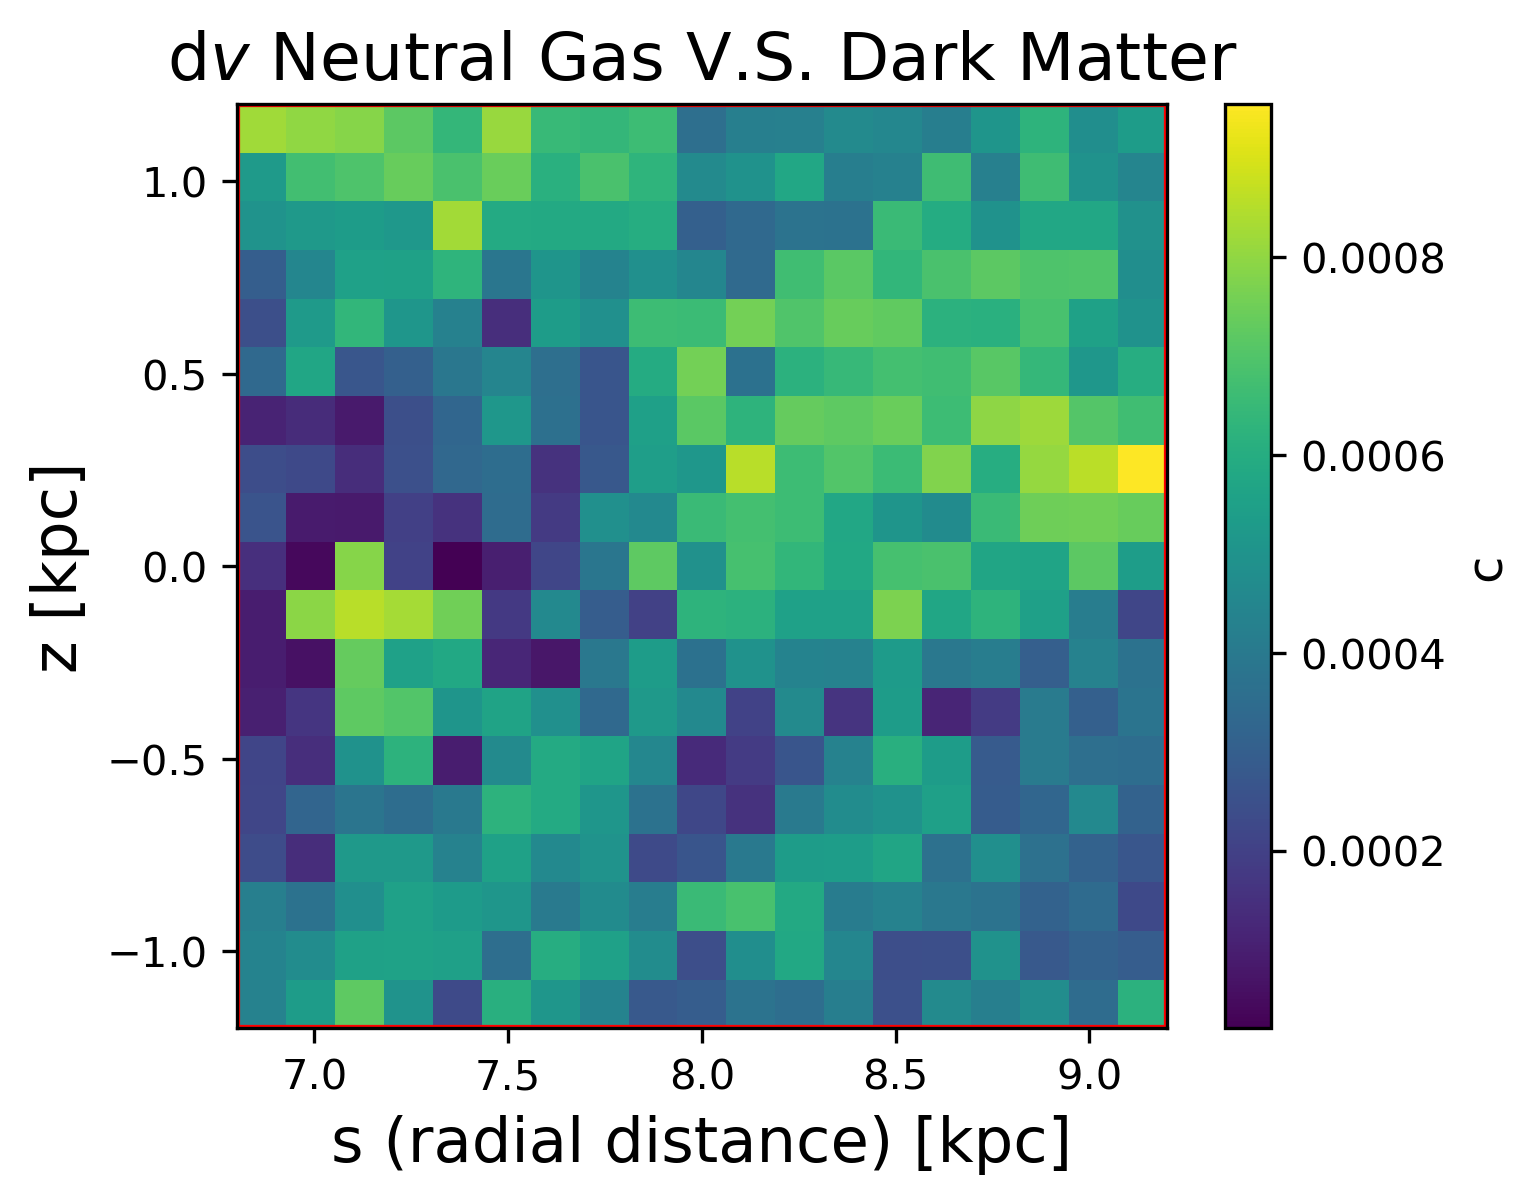

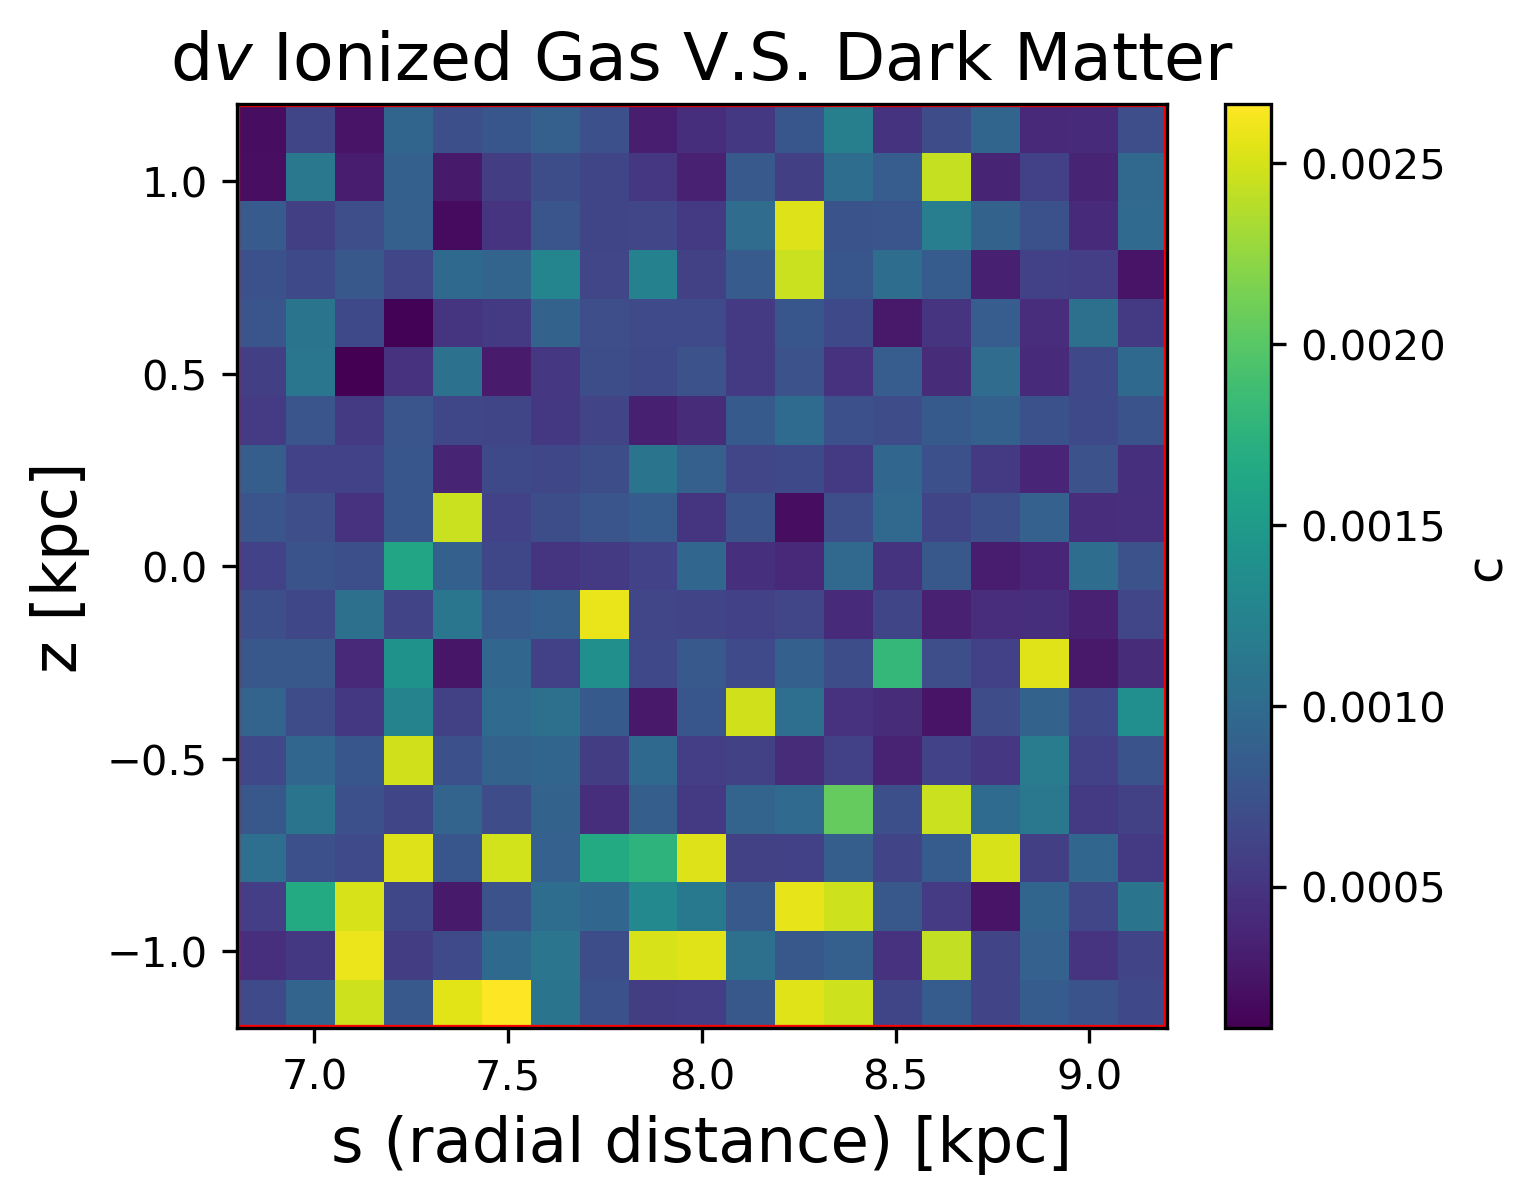

In [25]:
bins_s = np.linspace(6.8,9.2,20)
bins_z = np.linspace(-1.2,1.2,20)

# bins_s = np.linspace(0,10,50) 
# bins_z = np.linspace(-4,4,50) 

for i, dictt in enumerate([dark_mat, ioni_gas, neut_gas]):
    res_x = scipy.stats.binned_statistic_2d(dictt["rad_distances"][dictt["within_cube"]],
                                            dictt["coords"][dictt["within_cube"]][:,2], 
                                            dictt["v"][dictt["within_cube"]][:,0], statistic='median', bins=[bins_s, bins_z])
    res_y = scipy.stats.binned_statistic_2d(dictt["rad_distances"][dictt["within_cube"]],
                                            dictt["coords"][dictt["within_cube"]][:,2], 
                                            dictt["v"][dictt["within_cube"]][:,1], statistic='median', bins=[bins_s, bins_z])
    res_z = scipy.stats.binned_statistic_2d(dictt["rad_distances"][dictt["within_cube"]],
                                            dictt["coords"][dictt["within_cube"]][:,2], 
                                            dictt["v"][dictt["within_cube"]][:,2], statistic='median', bins=[bins_s, bins_z])

    # Replace this with voronoi to make it more accurate!!
    for res in [res_x, res_y, res_z]:
        res[0][np.isnan(res[0])] = np.min(res[0][np.logical_not(np.isnan(res[0]))])
        # res[0] = ((res[0]*u.km/u.s).to(u.m/u.s)/cst.c)

    dictt["v_x"], dictt["v_y"], dictt["v_z"] = res_x[0], res_y[0], res_z[0]

dv_neut = np.sqrt((dark_mat["v_x"] - neut_gas["v_x"])**2 + (dark_mat["v_y"] - neut_gas["v_y"])**2 + (dark_mat["v_z"] - neut_gas["v_z"])**2)
dv_ioni = np.sqrt((dark_mat["v_x"] - ioni_gas["v_x"])**2 + (dark_mat["v_y"] - ioni_gas["v_y"])**2 + (dark_mat["v_z"] - ioni_gas["v_z"])**2)
dv_neut, dv_ioni = ((dv_neut * u.km/u.s).to(u.m/u.s)/cst.c).value, ((dv_ioni * u.km/u.s).to(u.m/u.s)/cst.c).value


S, Z = np.meshgrid(res_x[1], res_x[2])

fig, axs = plt.subplots(1, 1, dpi=300, sharex = True, sharey = True, figsize=(5,4))
axs.set_xlabel("s (radial distance) [kpc]",size=15)
axs.set_ylabel("z [kpc]",size=15)
norm = mcolors.LogNorm(vmin=np.min(dv_neut), vmax=dv_neut.max())
c = axs.pcolormesh(S, Z, (dv_neut).T)
axs.set_title(r"d$v$ Neutral Gas V.S. Dark Matter", size=16)
axs.hlines([-1.2,1.2], [6.8, 6.8], [9.2,9.2], colors="red")
axs.vlines([6.8,9.2], [-1.2, -1.2], [1.2,1.2], colors="red")
cbar = fig.colorbar(c, ax=axs)
cbar.set_label(r'c', size=12)
plt.show()

fig, axs = plt.subplots(1, 1, dpi=300, sharex = True, sharey = True, figsize=(5,4))
axs.set_xlabel("s (radial distance) [kpc]",size=15)
axs.set_ylabel("z [kpc]",size=15)
norm = mcolors.LogNorm(vmin=np.min(dv_ioni), vmax=dv_ioni.max())
c = axs.pcolormesh(S, Z, (dv_ioni).T)
axs.set_title(r"d$v$ Ionized Gas V.S. Dark Matter", size=16)
axs.hlines([-1.2,1.2], [6.8, 6.8], [9.2,9.2], colors="red")
axs.vlines([6.8,9.2], [-1.2, -1.2], [1.2,1.2], colors="red")
cbar = fig.colorbar(c, ax=axs)
cbar.set_label(r'c', size=12)
plt.show()

In [ ]:
from scipy import stats
from scipy.optimize import minimize

def find_mode(data):
    params = stats.norm.fit(data*1e24)
    
    def your_density(x):
        return -stats.norm.pdf(x,*params)
    
    return minimize(your_density,0).x[0] / 1e24

print(find_mode(dark_mat["density"].flatten()))
print(find_mode(ioni_gas["density"].flatten()))
print(find_mode(neut_gas["density"].flatten()))

In [ ]:
plt.scatter(bin_centers_s, bin_centers_z, s=4, color="red")
plt.scatter(S, Z, s=4, color="blue")

In [29]:
bin_centers_s = (hist[1][1:] + hist[1][:-1])/2
bin_centers_z = (hist[2][1:] + hist[2][:-1])/2
S, Z = np.meshgrid(bin_centers_s, bin_centers_z)
S.shape

(19, 19)

In [32]:
ioni_gas["density"].shape

(19, 19)

In [30]:
S.shape

(19, 19)

In [ ]:
grid_c = np.dstack(np.array([bin_centers_s, bin_centers_z])).reshape(-1,2)
grid_c.shape

In [ ]:
# use this one
grid_c = np.dstack(np.array([bin_centers_s, bin_centers_z])).reshape(-1,2)
np.save('../data/uv-averaged-grid-coords.npy', grid_c)

In [23]:
dv_neut

<Quantity [[4.35074825e-04, 4.39894607e-04, 4.20677137e-04,
            2.34020684e-04, 2.16446087e-04, 2.13570292e-04,
            1.02278058e-04, 9.59441919e-05, 9.44539677e-05,
            1.45494874e-04, 2.64254547e-04, 2.39294565e-04,
            1.09495440e-04, 3.36145221e-04, 2.46381333e-04,
            2.96645510e-04, 5.00480933e-04, 5.25217827e-04,
            8.21995540e-04],
           [5.32118347e-04, 4.72196430e-04, 3.74247884e-04,
            1.37775878e-04, 3.20721688e-04, 1.41498262e-04,
            1.66028894e-04, 6.28112978e-05, 7.92768940e-04,
            3.99069818e-05, 8.77944923e-05, 2.28127375e-04,
            1.36420865e-04, 5.71701949e-04, 5.27435579e-04,
            4.48549847e-04, 5.23062414e-04, 6.72619396e-04,
            8.00384714e-04],
           [7.21478509e-04, 5.54138960e-04, 4.80550353e-04,
            5.23392814e-04, 3.83281526e-04, 4.94467518e-04,
            7.21838568e-04, 7.33409313e-04, 8.53959663e-04,
            7.83153910e-04, 8.50445102e-05

# Save all s v.s. z arrays

In [33]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    np.save("../data/uv-averaged-"+dictt["short-name"]+".npy", dictt["density"].value)

np.save("../data/uv-averaged-ioni_gas_temp.npy", temperature)
np.save("../data/uv-averaged-dv_ioni.npy", dv_ioni)
np.save("../data/uv-averaged-dv_neut.npy", dv_neut)
# S, Z = np.meshgrid(hist[1][1:], hist[2][1:])
bin_centers_s = (hist[1][1:] + hist[1][:-1])/2
bin_centers_z = (hist[2][1:] + hist[2][:-1])/2
S, Z = np.meshgrid(bin_centers_s, bin_centers_z)
grid_c = np.dstack(np.array([S, Z])).reshape(-1,2)
np.save('../data/uv-averaged-grid-coords.npy', grid_c)

In [ ]:
print(np.max(temperature))
temperature = replace_max_with_second_largest(temperature)
print(np.max(temperature))


In [ ]:
plt.figure(dpi=300)

plt.xlabel(r'T ioni [K]',size=15)
plt.ylabel("count",size=15)

grid_avg_temp = np.average(temperature.flatten())
res = plt.hist(temperature.flatten(), bins=20)
plt.title(dictt["name"], size=15)
plt.vlines(total_avg_temp, 0, np.max(res[0]), color="red", label="Pre-grid average")
plt.vlines(grid_avg_temp, 0, np.max(res[0]), color="blue", label="Post-grid average")

plt.legend()
plt.show()

In [ ]:
np.min(temperature)

In [ ]:
np.max(temperature)

In [ ]:
dark_mat["within_cube"] = np.where((np.abs(dark_mat["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(dark_mat["coords"][:,1]) < cube_length/2) &
                                   (np.abs(dark_mat["coords"][:,2]) < cube_length/2))
neut_gas["within_cube"] = np.where((np.abs(neut_gas["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(neut_gas["coords"][:,1]) < cube_length/2) &
                                   (np.abs(neut_gas["coords"][:,2]) < cube_length/2))
ioni_gas["within_cube"] = np.where((np.abs(ioni_gas["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(ioni_gas["coords"][:,1]) < cube_length/2) &
                                   (np.abs(ioni_gas["coords"][:,2]) < cube_length/2))

for dictt in [dark_mat, ioni_gas, neut_gas]:
    plt.figure(dpi=300)
    plt.hist2d(dictt["distances"][dictt["within_cube"]], 
               dictt["coords"][dictt["within_cube"]][:,2],
               bins=[np.linspace(0,10,20), np.linspace(-5,5,20)])
    plt.show()

In [ ]:


for dictt in [dark_mat, ioni_gas, neut_gas]:
    plt.figure(dpi=300)
    plt.hist2d(dictt["distances"][dictt["within_cube"]], 
               dictt["coords"][dictt["within_cube"]][:,2],
               bins=[np.linspace(7.4,8.6,10), np.linspace(-0.6,0.6,10)])
    plt.show()

In [ ]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    temp = dictt["coords"][dictt["within_cube"]]
    temp[:,1] -= offset_y
    dictt["coords"][dictt["within_cube"]] = temp
    dictt["coords"][dictt["within_cube"]][:,1]

In [ ]:
np.min(dictt["coords"][dictt["within_cube"]][:,1])

In [ ]:
for dictt in [dark_mat, ioni_gas, neut_gas]:
    plt.figure(dpi=300)
    scat = plt.scatter(dictt["coords"][dictt["within_cube"]][:,0],
                dictt["coords"][dictt["within_cube"]][:,1], s=3, 
                       c=np.abs(dictt["coords"][dictt["within_cube"]][:,2]),
                       # c=dictt["masses"], 
                       cmap='autumn')
    plt.colorbar(scat, label='|z| [kpc]')
    plt.xlabel("x [kpc]",size=15)
    plt.ylabel("y [kpc]",size=15)
    plt.title(dictt["name"], size=16)
    plt.text(0.95, 0.05, str(len(dictt["masses"]))+" particles", 
         transform=plt.gca().transAxes, 
         fontsize=12, 
         verticalalignment='bottom', 
         horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.7))
    plt.savefig("../visuals/Radio-particle-plot-"+"("+str(offset_x)+", "+str(offset_y)+")"+dictt["short-name"]+".svg", bbox_inches="tight")
    plt.savefig("../visuals/Radio-particle-plot-"+"("+str(offset_x)+", "+str(offset_y)+")"+dictt["short-name"]+".png", bbox_inches="tight")
    # plt.savefig("../visuals/Radio-particle-plot-"+"radial-offset"+dictt["short-name"]+".svg", bbox_inches="tight")
    # plt.savefig("../visuals/Radio-particle-plot-"+"radial-offset"+dictt["short-name"]+".png", bbox_inches="tight")
    plt.show()

In [ ]:
# use histograms to obtain mass counts and velocities within each voxel
print(f">> binning masses", end="")
for dict in [dark_mat, neut_gas, ioni_gas]:
    
    # bin all particle masses within cube, weighing by their mass
    dict["mass_count"], bin_edges, bin_numbers = stats.binned_statistic_dd(dict["coords"][dict["within_cube"]],
                          dict["masses"],
                          statistic='sum',
                          bins=(bins,bins,bins),
                          expand_binnumbers=True)
    print(".", end="")

# velocity calculations are currently broken -- should be done after calculating the voronoied density cubes
    # bin all particle velocities within cube, weighing by their mass
    velocities, bin_edges, bin_numbers = stats.binned_statistic_dd(dict["coords"][dict["within_cube"]],
                          [dict["v"][:,0], dict["v"][:,1], dict["v"][:,2]]*dict["masses"],
                          statistic='sum',
                          bins=(bins,bins,bins),
                          expand_binnumbers=True,
                          binned_statistic_result=None)
    
    print(".", end="")
    dict["v_x"], dict["v_y"], dict["v_z"] = velocities[0] * u.km/u.s, velocities[1] * u.km/u.s, velocities[2] * u.km/u.s

    # finish weighed average calculation
    non_empty_v_x, non_empty_v_y, non_empty_v_z = velocities[0]!=0, velocities[1]!=0, velocities[2]!=0    
    dict["v_x"][non_empty_v_x] = velocities[0][non_empty_v_x] / dict["mass_count"][non_empty_v_x] * u.km/u.s
    dict["v_y"][non_empty_v_y] = velocities[0][non_empty_v_y] / dict["mass_count"][non_empty_v_y] * u.km/u.s
    dict["v_z"][non_empty_v_z] = velocities[0][non_empty_v_z] / dict["mass_count"][non_empty_v_z] * u.km/u.s
    
    # velocities[non_empty_cells] = velocities[non_empty_cells] / dict["mass_count"][dict["mass_count"]!=0]
    # dict["v_x"], dict["v_y"], dict["v_z"] = velocities[0], velocities[1], velocities[2]

# dv_neut = np.sqrt((dark_mat["v_x"] - neut_gas["v_x"])**2 + (dark_mat["v_y"] - neut_gas["v_y"])**2 + (dark_mat["v_z"] - neut_gas["v_z"])**2)
# dv_ioni = np.sqrt((dark_mat["v_x"] - ioni_gas["v_x"])**2 + (dark_mat["v_y"] - ioni_gas["v_y"])**2 + (dark_mat["v_z"] - ioni_gas["v_z"])**2)
# dv_neut, dv_ioni = (dv_neut * u.km/u.s).to(u.m/u.s), (dv_ioni * u.km/u.s).to(u.m/u.s)

print("\n")

In [ ]:
# print(f">> printing some statistics...")
# print("\tthere are {} x {} x {} cubes: ".format(voxel_resolution,voxel_resolution,voxel_resolution), voxel_resolution**3)
# print("\t-------------------------------- ")
# print("\t  number of cubes with neut_gas: ", np.shape(neut_gas["v_x"][abs(neut_gas["v_x"])>0])[0])
# print("\t  number of cubes with dark_mat: ", np.shape(dark_mat["v_x"][abs(dark_mat["v_x"])>0])[0])
# print("\t    number of overlapping cubes: ", np.shape((dark_mat["v_x"] - neut_gas["v_x"])[np.abs((dark_mat["v_x"] - neut_gas["v_x"]))>0])[0])
# print("\t-------------------------------- ")
# print("\t  number of cubes with ioni_gas: ", np.shape(ioni_gas["v_x"][abs(ioni_gas["v_x"])>0])[0])
# print("\t  number of cubes with dark_mat: ", np.shape(dark_mat["v_x"][abs(dark_mat["v_x"])>0])[0])
# print("\t    number of overlapping cubes: ", np.shape((dark_mat["v_x"] - ioni_gas["v_x"])[np.abs((dark_mat["v_x"] - ioni_gas["v_x"]))>0])[0])

In [ ]:
# bin all ionized gas particle temperatures within cube, weighing by their mass
print(f">> binning ioni_gas temperatures, weighed by mass", end="")
temperatures, bin_edges, bin_numbers = stats.binned_statistic_dd(ioni_gas["coords"][ioni_gas["within_cube"]], 
                      gas_temp[ionized_filter][ioni_gas["within_cube"]]*ioni_gas["masses"], 
                      statistic='sum', 
                      bins=(bins,bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

ioni_gas["temperatures"] = temperatures * u.K
non_empty_temp = temperatures != 0
ioni_gas["temperatures"][non_empty_temp] = temperatures[non_empty_temp] / ioni_gas["mass_count"][non_empty_temp] * u.K

# replace NaN temperature of empty voxels with 0
# ioni_gas["temperatures"][np.isnan(ioni_gas["temperatures"])] = 0 * u.K

In [ ]:
# del temperatures
# del non_empty_v_x, non_empty_v_x, non_empty_v_x
del non_empty_temp
del velocities
del bin_numbers
del bin_edges
# for dict in [dark_mat, neut_gas, ioni_gas]:
#     del dict["v_x"], dict["v_y"], dict["v_z"]
del dict


In [ ]:
# del dv_ioni, dv_neut

In [ ]:
# total = 0
# # print(bins.nbytes/1024/1024/1024)
# for item in dark_mat.keys():
#     try:
#         dark_mat[item] = dark_mat[item].astype(np.float32)
#         ioni_gas[item] = ioni_gas[item].astype(np.float32)
#         neut_gas[item] = neut_gas[item].astype(np.float32)
#         print(item, dark_mat[item].nbytes/1024/1024/1024, "gb")
#         print(item, ioni_gas[item].nbytes/1024/1024/1024, "gb")
#         print(item, neut_gas[item].nbytes/1024/1024/1024, "gb")
#         total = total + dark_mat[item].nbytes/1024/1024/1024 + ioni_gas[item].nbytes/1024/1024/1024 + neut_gas[item].nbytes/1024/1024/1024
#     except:
#         print("--", item)
# print("Total: ", total)


In [ ]:
import gc
gc.collect()

In [ ]:
# calculate densities from mass counts
print(f">> calculating density voxels from mass count voxels")
print(f"---", end="\r")
dark_mat["density"] = (dark_mat["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
print(f"#--", end="\r")
neut_gas["density"] = (neut_gas["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
print(f"##-", end="\r")
ioni_gas["density"] = (ioni_gas["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
print(f"###")

In [ ]:
# calculate the delta in velocities between dark matter and visible matter
print(f">> calculating velocity differences between dark matter and visible matter")
print(f"--", end="\r")
dv_neut = np.sqrt((dark_mat["v_x"] - neut_gas["v_x"])**2 + (dark_mat["v_y"] - neut_gas["v_y"])**2 + (dark_mat["v_z"] - neut_gas["v_z"])**2).to(u.m/u.s)
print(f"#-", end="\r")
dv_ioni = np.sqrt((dark_mat["v_x"] - ioni_gas["v_x"])**2 + (dark_mat["v_y"] - ioni_gas["v_y"])**2 + (dark_mat["v_z"] - ioni_gas["v_z"])**2).to(u.m/u.s)
print(f"##")

In [ ]:
# we now have everything that we need:
# dark_mat["density"], neut_gas["density"], ioni_gas["density"], dv_neut, dv_ioni, ioni_gas["temperatures"]

In [ ]:

print(f"\n>> saving files for voronoi voxelization's nearest neighbour search")

xx_c = np.meshgrid(bin_centers,bin_centers, bin_centers)[0]#.astype(np.float32)
yy_c = np.meshgrid(bin_centers,bin_centers, bin_centers)[1]#.astype(np.float32)
zz_c = np.meshgrid(bin_centers,bin_centers, bin_centers)[2]#.astype(np.float32)

# These two are equivalent:
# grid_c = np.dstack(np.array([xx_c,yy_c, zz_c])).reshape(-1,3)
grid_c = np.vstack((xx_c.ravel(), yy_c.ravel(), zz_c.ravel())).T
np.save('../data/FIRE/grid-coords-uv.npy', grid_c)
print(f"\tgrid coordinates:\n\t../data/FIRE/grid-coords.npy\n")

print(f"\tdensities:")
for dictt in [dark_mat, neut_gas, ioni_gas]:
    non_empty_ioni_gas = dictt["density"]!=0
    non_empty_points = np.array([xx_c[non_empty_ioni_gas], yy_c[non_empty_ioni_gas], zz_c[non_empty_ioni_gas]]).transpose()

    save_file =  '../data/FIRE/non-empty-coords-'+dictt["short-name"]+'-uv.npy'
    np.save(save_file, non_empty_points)
    print(f"\t{save_file}")

print(f"\n\tionized gas temperature:")
non_empty_ioni_gas = ioni_gas["temperatures"]!=0
non_empty_points = np.array([xx_c[non_empty_ioni_gas], yy_c[non_empty_ioni_gas], zz_c[non_empty_ioni_gas]]).transpose()
save_file =  '../data/FIRE/non-empty-coords-'+'ioni_gas-temp'+'-uv.npy'
np.save(save_file, non_empty_points)
print(f"\t{save_file}")

print(f"\n\trelative velocity, ionized gas vs dark matter:")
non_empty_ioni_gas = dv_ioni!=0
non_empty_points = np.array([xx_c[non_empty_ioni_gas], yy_c[non_empty_ioni_gas], zz_c[non_empty_ioni_gas]]).transpose()
save_file =  '../data/FIRE/non-empty-coords-'+'dv_ioni'+'-uv.npy'
np.save(save_file, non_empty_points)
print(f"\t{save_file}")

print(f"\n\trelative velocity, neutral gas vs dark matter:")
non_empty_ioni_gas = dv_neut!=0
non_empty_points = np.array([xx_c[non_empty_ioni_gas], yy_c[non_empty_ioni_gas], zz_c[non_empty_ioni_gas]]).transpose()
save_file =  '../data/FIRE/non-empty-coords-'+'dv_neut'+'-uv.npy'
np.save(save_file, non_empty_points)
print(f"\t{save_file}")

In [ ]:
def plot_pre_voronoi(x, unit_label, save_name):
    z_slice_min, z_slice_max = [-0.5,0.5]
    mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
    slice_count = np.sum(x[:,:,mask], axis=2).value
    # slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
    plt.figure(dpi=500)
    plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(unit_label, fontsize=20)
    plt.xlabel('$x$ [kpc]', size=20)
    plt.ylabel('$y$ [kpc]', size=20)
    plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
    plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)
    
    plt.title("Pre-voronoi", size=20)
    
    plt.savefig(save_name+".png", bbox_inches='tight')
    plt.savefig(save_name+".svg", bbox_inches='tight')
    
    plt.show()

def plot_post_voronoi(x, unit_label, save_name):
    z_slice_min, z_slice_max = [-0.5, 0.5]
    mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
    slice_count = np.average(x[:,:,mask], axis=2).value
    # slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
    plt.figure(dpi=500)
    plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
    
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(unit_label, fontsize=20)
    plt.xlabel('$x$ [kpc]', size=20)
    plt.ylabel('$y$ [kpc]', size=20)
    plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
    plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)
    
    plt.title("Post-voronoi", size=20)
    
    plt.savefig(save_name+".png", bbox_inches='tight')
    plt.savefig(save_name+".svg", bbox_inches='tight')
    
    # plt.close()
    plt.show()

def compute_voronoi_cube_density(grid_c, grid_ids, dict):
    non_empty_points = dict["density"] != 0
    
    non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
    quantity = np.reshape(dict["density"], voxel_resolution**3)

    # divide by the bincount to average the density across the voronoi volumes
    voronoied_result = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
    voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

    return voronoied_result

def compute_voronoi_cube_temp(gric_c, grid_ids, dict=ioni_gas):
    non_empty_points = dict["temperatures"] != 0
    
    non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
    quantity = np.reshape(dict["temperatures"], voxel_resolution**3)

    # don't divide by the bincount here, we don't want to average across voronoi volumes for the temperatures
    voronoied_result = quantity[non_empty_points_reshaped][grid_ids] # / np.bincount(grid_ids)[grid_ids]
    voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

    return voronoied_result    

def compute_voronoi_cube_vel(gric_c, grid_ids, dict, dir = "v_x"):
    non_empty_points = dict[dir] != 0
    
    non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
    quantity = np.reshape(dict[dir], voxel_resolution**3)

    # don't divide by the bincount here, we don't want to average across voronoi volumes for the temperatures
    voronoied_result = quantity[non_empty_points_reshaped][grid_ids] # / np.bincount(grid_ids)[grid_ids]
    voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

    return voronoied_result   

In [ ]:
# load grid point centres from a file to speed up code
# grid_c = np.load("../data/FIRE/grid-coords.npy")

In [ ]:
counter = np.array([0])
m = 30

In [ ]:
# counter = np.array([0])
def advance():
    print("#"*counter[0] + "-"*(m-counter[0]), end="\r")
    counter[0] = counter[0] + 1

advance()

In [ ]:
cubes = {}

# Final results:
advance()
grid_ids_dark = np.load('../data/FIRE/grid-ids--dark_mat-cKDTree-uv.npy').astype(int)
advance()
grid_ids_ioni = np.load('../data/FIRE/grid-ids--ioni_gas-cKDTree-uv.npy').astype(int)
advance()
grid_ids_neut = np.load('../data/FIRE/grid-ids--neut_gas-cKDTree-uv.npy').astype(int)
advance()

# ionized gas density
cubes["ioni_gas_density"] = compute_voronoi_cube_density(grid_c, grid_ids_ioni, ioni_gas)
advance()
plot_pre_voronoi(ioni_gas["density"],         'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-final-ioni_gas-density-pre-uv")
advance()
plot_post_voronoi(cubes["ioni_gas_density"],  'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-final-ioni_gas-density-post-uv")
advance()

# ionized gas temperature
cubes["ioni_gas_temp"] = compute_voronoi_cube_temp(grid_c, grid_ids_ioni, ioni_gas)
advance()
plot_pre_voronoi(ioni_gas["temperatures"],   'Temperature [K]', "../visuals/voronoi-final-ioni_gas-temp-pre-uv")
advance()
plot_post_voronoi(cubes["ioni_gas_temp"],    'Temperature [K]', "../visuals/voronoi-final-ioni_gas-temp-post-uv")
advance()

# dark matter density
cubes["dark_mat_density"] = compute_voronoi_cube_density(grid_c, grid_ids_dark, dark_mat)
advance()
plot_pre_voronoi(dark_mat["density"],         'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-final-dark_mat-density-pre-uv")
advance()
plot_post_voronoi(cubes["dark_mat_density"],  'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-final-dark_mat-density-post-uv")
advance()

# neutral gas density
cubes["neut_gas_density"] = compute_voronoi_cube_density(grid_c, grid_ids_neut, neut_gas)
advance()
plot_pre_voronoi(neut_gas["density"],         'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-final-neut_gas-density-pre-uv")
advance()
plot_post_voronoi(cubes["neut_gas_density"],  'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-final-neut_gas-density-post-uv")
advance()

# change in velocities
dark_mat_x = compute_voronoi_cube_vel(grid_c, grid_ids_dark, dark_mat, "v_x")
advance()
dark_mat_y = compute_voronoi_cube_vel(grid_c, grid_ids_dark, dark_mat, "v_y")
advance()
dark_mat_z = compute_voronoi_cube_vel(grid_c, grid_ids_dark, dark_mat, "v_z")
advance()

ioni_gas_x = compute_voronoi_cube_vel(grid_c, grid_ids_ioni, ioni_gas, "v_x")
advance()
ioni_gas_y = compute_voronoi_cube_vel(grid_c, grid_ids_ioni, ioni_gas, "v_y")
advance()
ioni_gas_z = compute_voronoi_cube_vel(grid_c, grid_ids_ioni, ioni_gas, "v_z")
advance()

neut_gas_x = compute_voronoi_cube_vel(grid_c, grid_ids_neut, neut_gas, "v_x")
advance()
neut_gas_y = compute_voronoi_cube_vel(grid_c, grid_ids_neut, neut_gas, "v_y")
advance()
neut_gas_z = compute_voronoi_cube_vel(grid_c, grid_ids_neut, neut_gas, "v_z")
advance()

cubes["dv_neut"] = np.sqrt((dark_mat_x - neut_gas_x)**2 + (dark_mat_y - neut_gas_y)**2 + (dark_mat_z - neut_gas_z)**2).to(u.m/u.s)
advance()
cubes["dv_ioni"] = np.sqrt((dark_mat_x - ioni_gas_x)**2 + (dark_mat_y - ioni_gas_y)**2 + (dark_mat_z - ioni_gas_z)**2).to(u.m/u.s)
advance()
plot_pre_voronoi(dv_neut,             'Velocity  [m$\cdot$s$^{-1}$]', "../visuals/voronoi-final-dv_neut-pre-uv")
advance()
plot_post_voronoi(cubes["dv_neut"],   'Velocity  [m$\cdot$s$^{-1}$]', "../visuals/voronoi-final-dv_neut-post-uv")
advance()
plot_pre_voronoi(dv_ioni,             'Velocity  [m$\cdot$s$^{-1}$]', "../visuals/voronoi-final-dv_ioni-pre-uv")
advance()
plot_post_voronoi(cubes["dv_ioni"],   'Velocity  [m$\cdot$s$^{-1}$]', "../visuals/voronoi-final-dv_ioni-post-uv")
advance()
    
    # change in velocities

In [ ]:
savee = True
if savee:
    counter = np.array([0])
    m = len(cubes.keys())
    advance()
    for cube in cubes:
        np.save("../data/FIRE/cubes/cube-"+cube+"-uv.npy", cubes[cube].value)
        advance()

In [ ]:
DENSITY = np.sum(dark_mat["density"])
print(f">> checking total dark matter density:")
print(f"  >> argmin:\t{np.sum(voronoied_result_1)}\n  >> cKDTree:\t{np.sum(voronoied_result_2)}\n  >> true:\t{DENSITY}")
SUM = np.sum(cubes["dark_mat_density"])
print(f"  >> test\t{SUM}")
print(f"  >> diff ids:\t{(grid_ids_1 - grid_ids_2 != 0).sum()}/{len(grid_ids_1)} = {(grid_ids_1 - grid_ids_2 != 0).sum()/len(grid_ids_1)*100}%")

In [ ]:
DENSITY = np.sum(dark_mat["density"])
print(f">> checking total dark matter density:")
print(f"  >> true:\t{DENSITY}")
SUM = np.sum(cubes["dark_mat_density"])
print(f"  >> test\t{SUM}")


In [ ]:
len(cubes["dark_mat_density"])**3 * voxel_volume

In [ ]:
cubes["dark_mat_density"].shape

In [ ]:
20 * 20 * 20

In [ ]:
np.sum(dark_mat["density"] * voxel_volume.to(u.m**3))

In [ ]:
np.sum(dark_mat["density"])

In [ ]:
# (np.sum(dark_mat["mass_count"]) * u.Msun).to(u.kg)

dark_mat["density"] = (dark_mat["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
dark_mat["density"]

In [ ]:
MASS_PART = np.sum(dark_mat["masses"]*u.Msun).to(u.kg)
DENSITY = np.sum(cubes["dark_mat_density"])
VOLUME = (len(cubes["dark_mat_density"])**3 * voxel_volume).to(u.m**3)
# VOLUME = (8000*u.kpc**3).to(u.m**3)
VOLUME = voxel_volume.to(u.m**3)
MASS_CUBE = DENSITY * VOLUME
print(f">> PART: \t {MASS_PART} \n>> CUBE: \t {MASS_CUBE}")

In [ ]:
plot_post_voronoi(cubes["neut_gas_density"],  'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-final-neut_gas-density-post-+-4kpc")

In [ ]:
plot_post_voronoi(cubes["neut_gas_density"],  'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-final-neut_gas-density-post")

In [ ]:
plot_post_voronoi(voronoied_result_1,   'Temperature [K]', "../visuals/voronoi-ioni_gas-temp-post")
plot_post_voronoi(voronoied_result_2,   'Temperature [K]', "../visuals/voronoi-ioni_gas-temp-post")

In [ ]:
binned_masses, bin_edges, bin_numbers = stats.binned_statistic_dd(points, 
                      masses, 
                      statistic='sum', 
                      bins=(bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

binned_masses = binned_masses[0]

binned_points, bin_edges, bin_numbers = stats.binned_statistic_dd(points, 
                      velocities*masses, 
                      statistic='sum', 
                      bins=(bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

binned_points = binned_points[0] #/ binned_masses

select_binned_points = np.reshape(binned_points,(256,))!=0

# finish calculating the average velocitites by dividing by the total mass in each bin
# refer to only nonempty points to avoid divisions by 0.
binned_points[binned_points!=0] = binned_points[binned_points!=0] / binned_masses[binned_masses!=0]

In [ ]:
# velocity calculations are currently broken -- should be done after calculating the voronoied density cubes
dict = ioni_gas
# bin all particle velocities within cube, weighing by their mass
velocities_pre, bin_edges, bin_numbers = stats.binned_statistic_dd(dict["coords"][dict["within_cube"]],
                      [dict["v"][:,0], dict["v"][:,1], dict["v"][:,2]]*dict["masses"],
                      statistic='sum',
                      bins=(bins,bins,bins),
                      expand_binnumbers=True,
                      binned_statistic_result=None)

#     print(".", end="")

# finish weighed average calculation
velocities = velocities_pre / dict["mass_count"]
dict["v_x"], dict["v_y"], dict["v_z"] = velocities[0], velocities[1], velocities[2]


In [ ]:
quantity = np.reshape(velocities_pre[0], voxel_resolution**3)

In [ ]:
np.sum(quantity[non_empty_points_reshaped])

In [ ]:
np.sum(quantity)

In [ ]:
quantity = np.reshape(ioni_gas["density"], voxel_resolution**3)
np.sum(quantity[non_empty_points_reshaped_temp] - quantity[non_empty_points_reshaped])

In [ ]:
# import the grid_ids obtained using nearest-voxel-id-search script
grid_c   = np.load("../data/FIRE/grid-coords.npy")
grid_ids = np.load('../data/FIRE/grid-ids--ioni_gas.npy').astype(int)

non_empty_points = ioni_gas["density"]!=0

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
quantity = np.reshape(ioni_gas["density"], voxel_resolution**3)

voronoied_result = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [ ]:
plot_pre_voronoi(ioni_gas["density"], 'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-ioni_gas-density-pre")
plot_post_voronoi(voronoied_result,   'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-ioni_gas-density-post")
print(">> pre-voronoi sum:",np.sum(ioni_gas["density"]),"\t", "post-voronoi sum:", np.sum(voronoied_result))

In [ ]:
grid_ids = np.load('../data/FIRE/grid-ids--ioni_gas.npy').astype(int)
grid_ids_cdktree = np.load('../data/FIRE/grid-ids--ioni_gas-cKDTree.npy').astype(int)


In [ ]:
different_ids = grid_ids!=grid_ids_cdktree

In [ ]:
np.sum(ioni_gas["density"]) / (np.sum(ioni_gas["density"]) - np.sum(quantity[non_empty_points_reshaped][grid_ids])) * 100

In [ ]:
np.sum(ioni_gas["density"]) / (np.sum(ioni_gas["density"]) - np.sum(quantity[non_empty_points_reshaped][grid_ids_cdktree])) * 100

In [ ]:
np.sum(quantity[non_empty_points_reshaped][grid_ids] - quantity[non_empty_points_reshaped][grid_ids_cdktree])

In [ ]:
np.sum(quantity[non_empty_points_reshaped][grid_ids[grid_ids!=grid_ids_cdktree]])

In [ ]:
np.sum(quantity[non_empty_points_reshaped][grid_ids_cdktree[grid_ids!=grid_ids_cdktree]])

In [ ]:
np.sum(voronoied_result_2 - voronoied_result)

In [ ]:
grid_ids = np.load('../data/FIRE/grid-ids--ioni_gas-cKDTree.npy').astype(int)#np.load('../data/FIRE/grid-ids---ioni_gas.npy').astype(int)

non_empty_points = ioni_gas["density"]!=0

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
quantity = np.reshape(ioni_gas["density"], voxel_resolution**3)

voronoied_result_2 = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
voronoied_result_2 = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [ ]:
plot_pre_voronoi(ioni_gas["density"], 'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-ioni_gas--density-pre")
plot_post_voronoi(voronoied_result_2,   'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-ioni_gas--density-post")
print(">> pre-voronoi sum:",np.sum(ioni_gas["density"]),"\t", "post-voronoi sum:", np.sum(voronoied_result_2))

In [ ]:
non_empty_points

In [ ]:
# dark_mat["density"]!=0

In [ ]:
# import the grid_ids obtained using nearest-voxel-id-search script
grid_c   = np.load("../data/FIRE/grid-coords.npy")
grid_ids = np.load('../data/FIRE/grid-ids---dark_mat.npy').astype(int)

non_empty_points = dark_mat["density"]!=0

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
quantity = np.reshape(dark_mat["density"], voxel_resolution**3)

voronoied_result = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [ ]:
plot_pre_voronoi(dark_mat["density"], 'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-dark_mat-density-pre")
plot_post_voronoi(voronoied_result,   'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-dark_mat-density-post")
print(">> pre-voronoi sum:",np.sum(dark_mat["density"]),"\t", "post-voronoi sum:", np.sum(voronoied_result))

In [ ]:
# import the grid_ids obtained using nearest-voxel-id-search script
# grid_c   = np.load("../data/FIRE/grid-coords.npy")
grid_ids = np.load('../data/FIRE/grid-ids--dark_mat-cKDTree.npy').astype(int)

non_empty_points = dark_mat["density"]!=0

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
quantity = np.reshape(dark_mat["density"], voxel_resolution**3)

voronoied_result = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [ ]:
plot_pre_voronoi(dark_mat["density"], 'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-dark_mat-density-pre-cKDTree")
plot_post_voronoi(voronoied_result,   'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-dark_mat-density-post-cKDTree")
print(">> pre-voronoi sum:",np.sum(dark_mat["density"]),"\t", "post-voronoi sum:", np.sum(voronoied_result))

In [ ]:
print(np.sum(voronoied_result_2))
print(np.sum(voronoied_result))
print(np.sum(ioni_gas["density"]))

In [ ]:
print(np.sum(voronoied_result_2) - np.sum(ioni_gas["density"]))
print(np.sum(voronoied_result)   - np.sum(ioni_gas["density"]))

In [ ]:
np.where(voronoied_result_2 - voronoied_result > 0)

In [ ]:
np.max(voronoied_result_2)

In [ ]:
np.max(voronoied_result)

In [ ]:
np.max(voronoied_result_2) - np.max(voronoied_result)

In [ ]:
# import the grid_ids obtained using nearest-voxel-id-search script
grid_c   = np.load("../data/FIRE/grid-coords.npy")
grid_ids = np.load('../data/FIRE/grid-ids--neut_gas.npy').astype(int)

non_empty_points = neut_gas["density"]!=0

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
quantity = np.reshape(neut_gas["density"], voxel_resolution**3)

voronoied_result = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [ ]:
plot_pre_voronoi(ioni_gas["density"], 'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-neut_gas-density-pre")
plot_post_voronoi(voronoied_result,   'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-neut_gas-density-post")
print(">> pre-voronoi sum:",np.sum(neut_gas["density"]),"\t", "post-voronoi sum:", np.sum(voronoied_result))

In [ ]:
save_file =  '../data/FIRE/grid-ids-'+ioni_gas["short-name"]+'.npy'
# grid_ids = np.load(save_file)
grid_ids = np.load('../data/FIRE/grid-ids--ioni_gas-temp.npy')

grid_ids = grid_ids.astype(int)
# grid_ids = grid_ids.reshape((512,512,512))
non_empty_ioni_gas = ioni_gas["temperatures"]!=0
# non_empty_ioni_gas = ioni_gas["temperatures"]!=0

non_empty_points = np.array([xx_c[non_empty_ioni_gas], yy_c[non_empty_ioni_gas], zz_c[non_empty_ioni_gas]]).transpose()

In [ ]:
non_empty_gas_reshaped = np.reshape(non_empty_ioni_gas,(voxel_resolution**3))

In [ ]:
density = np.reshape(ioni_gas["temperatures"],(voxel_resolution**3))
# density = np.reshape(ioni_gas["temperatures"],(voxel_resolution**3))

In [ ]:
density[~non_empty_gas_reshaped]

In [ ]:
np.bincount(grid_ids)

In [ ]:
density[516]

In [ ]:
density[grid_ids]

In [ ]:
density[non_empty_gas_reshaped]

In [ ]:
result = density[non_empty_gas_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]

In [ ]:
np.min(result)

In [ ]:
# np.bincount(grid_ids)

In [ ]:

# # Example arrays A and B
# A = np.array([0, 0.5, 0, 0, 1., 0]) # weights
# B = np.array([1,   1, 1, 4, 4,  4])

# # Find the non-zero elements and their corresponding indices in A
# non_zero_indices = A.nonzero()[0]
# non_zero_values = A[non_zero_indices]

# # Count occurrences of each index in B
# index_counts = np.bincount(B)

# # Avoid division by zero by setting index_counts to 1 where it's zero
# index_counts = np.maximum(index_counts, 1)

# # Calculate the values for array C
# C = non_zero_values / index_counts[B[non_zero_indices]]

# print("Array C:", C)


In [ ]:
C[B]

In [ ]:
A[B] / np.bincount(B)[B]

In [ ]:
# import numpy as np

# # Example arrays A and B
# C = np.array([1,1,1,1,1,1,1])
# A = np.array([0.5, 2, 4]) # weights
# B = np.array([1,   1, 1, 2, 2,  2, 1])


# # Calculate the number of occurrences of each index in B
# occurrences = np.bincount(B)

# # Avoid division by zero by setting occurrences to 1 where it's zero
# # occurrences = np.maximum(occurrences, 1)

# # Create array C based on the specified logic
# C = A[B] #/ occurrences[B]

# # print("Array C:", C)


In [ ]:
# import numpy as np

# # Example arrays A and B
# A = np.array([0, 0.5, 0, 2, 0, 0, 0]) # weights
# B = np.array([1,   1, 1, 3, 3,  3, 1])


# # Calculate the number of occurrences of each index in B
# occurrences = np.bincount(B)

# # Avoid division by zero by setting occurrences to 1 where it's zero
# # occurrences = np.maximum(occurrences, 1)

# # Create array C based on the specified logic
# C = A[B] / occurrences[B]

# print("Array C:", C)


In [ ]:
non_empty_gas_sum[5]

In [ ]:
density[non_empty_gas_reshaped][5]

In [ ]:
density[non_empty_gas_reshaped][5] / np.sum(grid_ids == 5)

In [ ]:
np.sum(grid_ids == 5)

In [ ]:
np.bincount(grid_ids)[5]

In [ ]:
result = result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [ ]:
np.sum(result) * 20**3

In [ ]:
np.sum(ioni_gas["density"]) * 20**3

In [ ]:
np.sum(ioni_gas["temperatures"])

In [ ]:
np.sum(result)

In [ ]:
np.shape(slice_count)

In [ ]:
z_slice_min, z_slice_max = [0,0.5]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.sum(ioni_gas["temperatures"][:,:,mask], axis=2).value
# slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
plt.figure(dpi=500)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())


cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Temperature  [K]', fontsize=20)
# plt.xlabel('$x$ [kpc]', size=20)
# plt.ylabel('$y$ [kpc]', size=20)
plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)

plt.title("Pre-voronoi", size=20)

plt.savefig("../visuals/voronoi-ioni_gas-temp-pre.png", bbox_inches='tight')
plt.savefig("../visuals/voronoi-ioni_gas-temp-pre.svg", bbox_inches='tight')

plt.show()

In [ ]:
np.max(slice_count)

In [ ]:
z_slice_min, z_slice_max = [-0.5,0.5]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.average(result[:,:,mask], axis=2).value
# slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
plt.figure(dpi=500)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())


cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Temperature [K]', fontsize=20)
# plt.xlabel('$x$ [kpc]', size=20)
# plt.ylabel('$y$ [kpc]', size=20)
plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)

plt.title("Post-voronoi", size=20)

plt.savefig("../visuals/voronoi-ioni_gas-temp-post.png", bbox_inches='tight')
plt.savefig("../visuals/voronoi-ioni_gas-temp-post.svg", bbox_inches='tight')

plt.show()

In [ ]:
index_grid = (grid_c[:,2]>0) & (grid_c[:,2]<0.5)
grid_c[index_grid][:,0]

plt.figure(dpi=500)                                     #   vvvv -> seems inverted, added this as temp. correction
plt.scatter(grid_c[index_grid][:,0], grid_c[index_grid][:,1][::-1], marker='s', s=85, c=ioni_gas["density"][non_empty_ioni_gas][grid_ids][index_grid].value,
           norm = matplotlib.colors.LogNorm())
# plt.colorbar(label='Density')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('$\\rho$  [demo]', fontsize=20)
# plt.xlabel('$x$ [kpc]', size=20)
# plt.ylabel('$y$ [kpc]', size=20)
plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)

plt.title("Post-voronoi", size=20)
plt.savefig("plots/voronoi-demo-post-9.svg", bbox_inches='tight')
plt.show()

In [ ]:
print(np.shape(ioni_gas["density"]))

print(non_empty_ioni_gas)

In [ ]:
# np.save("cubes/dark_mat_density.txt", dark_mat["density"].value)
np.savez("cubes/cubes", dark_mat_density = dark_mat["density"].value, 
                        neut_gas_density = neut_gas["density"].value,
                        ioni_gas_density = ioni_gas["density"].value,
                        dv_neut = dv_neut.value,
                        dv_ioni = dv_ioni.value,
                        ioni_gas_temperatures = ioni_gas["temperatures"].value)

In [ ]:
# z_slice_min, z_slice_max = [-0.02,0.02]
# mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
# slice_count = np.sum(ioni_gas["density"][:,:,mask], axis=2)

# plt.figure(dpi=1000)
# plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
# plt.colorbar(label='$\\rho_{DM}$  [kg/m$^3$]')
# plt.xlabel('$x$ [kpc]')
# plt.ylabel('$y$ [kpc]')
# # plt.title("$\rho_{DM}$")
# plt.title("$\\rho_{DM}$ in $z$-slice: ["+str(z_slice_min)+", "+str(z_slice_max)+"] kpc")
# plt.show()

In [ ]:
# np.shape(neut_gas["coords"])
plt.figure(dpi=1000)
plt.scatter(ioni_gas["coords"][ioni_gas["within_cube"]][:,0], ioni_gas["coords"][ioni_gas["within_cube"]][:,1], s=0.01, color="blue")
plt.grid(visible=True, linestyle='-', linewidth=0.05, color="black")
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xticks(bins, size=0, labels=None)
plt.yticks(bins, size=0, labels=None)
plt.show()

In [ ]:
perform_sanity_check = True

if perform_sanity_check:
    z_slice_min, z_slice_max = [-10,10]
    mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)

    for dict in [ioni_gas, neut_gas, dark_mat]:
    
        slice_count = np.sum(dict["mass_count"][:,:,mask], axis=2)

        plt.figure(dpi=1000)
        plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
        plt.colorbar(label='$m$  [M$_{\odot}$]')
        plt.xlabel('$x$ [kpc]')
        plt.ylabel('$y$ [kpc]')
        plt.title(dict["name"]+": $m$ in z-slice: ["+str(z_slice_min)+", "+str(z_slice_max)+"] kpc", size=16)
        plt.savefig("plots/cube - "+dict["name"]+" mass.png", bbox_inches='tight')
        # plt.savefig("plots/cube - "+dict["name"]+" mass.svg", bbox_inches='tight')
        
        plt.show()

        ##############################################################################

        fig = plt.figure(dpi=400)
        ax = plt.gca()
        histo = ax.hist2d(dict["coords"][dict["within_cube"]][:,0],
                          dict["coords"][dict["within_cube"]][:,1],
                          bins = voxel_resolution,
                          norm = matplotlib.colors.LogNorm(), 
                          weights = dict["masses"])
        fig.colorbar(histo[3], ax=ax)
        ax.set_xlabel("x [kpc]",size=15)
        ax.set_ylabel("y [kpc]",size=15)
        ax.set_title(dict["name"]+" Distribution", size=16)

        plt.show()

        print(np.sum(slice_count - histo[0]))



In [ ]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.sum(dark_mat["density"][:,:,mask], axis=2).value

plt.figure(dpi=1000)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$\\rho$  [kg/m$^3$]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
# plt.title("$\rho_{DM}$")
plt.title(dark_mat["name"]+": $\\rho$ in z-slice: ["+str(z_slice_min)+", "+str(z_slice_max)+"] kpc", size=16)
plt.savefig("plots/cube - "+dark_mat["name"]+" density.png", bbox_inches='tight')
plt.show()

In [ ]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.average(ioni_gas["temperatures"][:,:,mask], axis=2).value

plt.figure(dpi=1000)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$T$  [K]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(ioni_gas["name"]+": Projected average $T$", size=16)
plt.savefig("plots/cube - "+ioni_gas["name"]+" temp.png", bbox_inches='tight')
plt.show()

In [ ]:
z_slice_min, z_slice_max = [-0.5,0.5]

In [ ]:
mask = (voxel_centers_2[:,:,:,2] >= z_slice_min) & (voxel_centers_2[:,:,:,2] < z_slice_max)

In [ ]:
ioni_gas["temperatures"][mask][np.isnan(ioni_gas["temperatures"][mask])] = 0
plt.hist(ioni_gas["temperatures"][mask])

In [ ]:
voxel_centers_2[mask][:,0]

In [ ]:
ioni_gas["temperatures"][mask]

In [ ]:
plt.scatter(voxel_centers_2[mask][:,0], voxel_centers_2[mask][:,1], c=ioni_gas["temperatures"][mask])

In [ ]:
slice_count

In [ ]:
np.shape((voxel_centers_2[:,:,:,2] >= z_slice_min) & (voxel_centers_2[:,:,:,2] < z_slice_max))

In [ ]:
z_slice_min, z_slice_max = [-0.02,0.02]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = ioni_gas["temperatures"][(voxel_centers_2[:,:,:,2] >= z_slice_min) & (voxel_centers_2[:,:,:,2] < z_slice_max)].value

plt.figure(dpi=400)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$T$  [K]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(dict["name"]+": $T$ at $z$ = 0 kpc", size=16)
plt.savefig("plots/cube - "+ioni_gas["name"]+" temp.png", bbox_inches='tight')
# plt.savefig("plots/cube - "+dict["name"]+" mass.svg", bbox_inches='tight')

plt.show()

In [ ]:
# generate set of ijk bin references 
voxel_centers_2 = np.transpose(np.meshgrid(bin_centers, bin_centers, bin_centers, indexing='ij')).swapaxes(0,2)
voxel_distances = np.sqrt(np.sum(voxel_centers_2**2, axis=3))
dark_mat["density"][np.where(voxel_distances < 4)]

radial_density = np.zeros(voxel_resolution)
r_array = np.linspace(0,cube_length/2, voxel_resolution)

i=0
for i in range(len(radial_density)-1):
    # average over the bins for which R_min < R < R_max
    radial_density[i] = np.average(dark_mat["density"][np.where((voxel_distances >= r_array[i]) & (voxel_distances <= r_array[i+1]))]).value
plt.plot(r_array+(r_array[1]-r_array[0])/2, radial_density, ".")

In [ ]:
2**9 / 2


In [ ]:
# filter by distance to Galaxy
max_distance_kpc = 10 * u.kpc
within_mw = part['dark'].prop('host.distance.total') < max_distance_kpc.value

# array of distances of each particle to the host Galaxy centre
dm = part['dark'].prop('host.distance.total')[within_mw]

num_bins = 2**9# 1200

# create bins array
distance_bins = np.linspace(0,max_distance_kpc.value,num_bins+1,endpoint=True) * u.kpc

# normalize bins
kpc_per_bin = max_distance_kpc / num_bins

# calculate spherical areas at each binned distance
avg_bin_distances = distance_bins[0:len(distance_bins)-1] + kpc_per_bin/2
avg_bin_areas = 4 * np.pi * avg_bin_distances**2

bin_volumes = 4/3*np.pi * (distance_bins[1:len(distance_bins)]**3 - distance_bins[0:len(distance_bins) - 1]**3)

# bin weighing by particle mass
# plt.figure(dpi=100)
# histogram_results = plt.hist(dm, bins=distance_bins.value, 
#                                  weights=part['dark']['mass'][within_mw], color="burlywood", alpha = 0.75)
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel("Mass [M$_\odot$]", size=20)
# # plt.savefig("plots/m12i dm mass.png", bbox_inches='tight')
# # plt.savefig("plots/m12i dm mass.svg", bbox_inches='tight')
# plt.show()

histogram_results = np.histogram(dm, bins=distance_bins.value, 
                                 weights=part['dark']['mass'][within_mw])

binned_dm_density = histogram_results[0] * u.Msun / bin_volumes
binned_dm_density_si = binned_dm_density.to(u.kg/u.m**3)

In [ ]:
plt.figure(dpi=300, figsize=(6,3))
# plt.plot(distance_bins[0:len(distance_bins) - 1].value, binned_dm_density_si.value, color="green", linewidth=0.2, label="m12i")
plt.scatter(distance_bins[0:len(distance_bins) - 1].value, binned_dm_density_si.value, color="green", s=1.5, label="m12i")
plt.scatter(r_array, radial_density, marker=".", s=3, color="red")

plt.yscale('log')
plt.xlabel("R [kpc]", size=15)
plt.ylabel(r'$\rho_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 15)

# plt.ylim([10**(-21),10**(-19)])
plt.xlim([0,5])
plt.legend(fontsize=9)

plt.show()

In [ ]:
# voxel_distances = np.sqrt(voxel_centers[0]**2 + voxel_centers[1]**2 + voxel_centers[2]**2)

# radial_density = np.zeros(voxel_resolution)
# # dr = cube_length/2 / voxel_resolution
# r_array = np.linspace(0,cube_length/2, voxel_resolution)

# i=0
# for i in range(len(radial_density)-1):
#     radial_density[i] = np.average(dark_mat["density"][(voxel_distances>=r_array[i]) & (voxel_distances<=r_array[i+1])]).value
# plt.plot(r_array, radial_density, ".")

In [ ]:
# OLD #################################################################
# bin all particles within cube, weighing by their mass
# dark_mat["mass_count"], voxel_coords = np.histogramdd(dark_mat["coords"][dark_mat["within_cube"]], bins=(bins,bins,bins), 
#                                                       weights=dark_mat["masses"])
# neut_gas["mass_count"], voxel_coords = np.histogramdd(neut_gas["coords"][neut_gas["within_cube"]], bins=(bins,bins,bins), 
#                                                       weights=neut_gas["masses"])
# ioni_gas["mass_count"], voxel_coords = np.histogramdd(ioni_gas["coords"][ioni_gas["within_cube"]], bins=(bins,bins,bins), 
#                                                       weights=ioni_gas["masses"])

In [ ]:
# obtain the bins indexes that each particle belongs to -- consider avoiding using scipy.stats.binned_statistic_dd
# values can take a list of data types that you want to bin
# dark_mat["bin_indexes"] = []
# for i in range(len(voxel_coords)):
#     dark_mat["bin_indexes"].append(np.digitize(dark_mat["coords"][dark_mat["within_cube"]][:, i], voxel_coords[i]))
# dark_mat["bin_indexes"] = np.concatenate(dark_mat["bin_indexes"]).reshape(np.shape(dark_mat["coords"][dark_mat["within_cube"]])) - 1

# neut_gas["bin_indexes"] = []
# for i in range(len(voxel_coords)):
#     neut_gas["bin_indexes"].append(np.digitize(neut_gas["coords"][neut_gas["within_cube"]][:, i], voxel_coords[i]))
# neut_gas["bin_indexes"] = np.concatenate(neut_gas["bin_indexes"]).reshape(np.shape(neut_gas["coords"][neut_gas["within_cube"]])) - 1

# ioni_gas["bin_indexes"] = []
# for i in range(len(voxel_coords)):
#     ioni_gas["bin_indexes"].append(np.digitize(ioni_gas["coords"][ioni_gas["within_cube"]][:, i], voxel_coords[i]))
# ioni_gas["bin_indexes"] = np.concatenate(ioni_gas["bin_indexes"]).reshape(np.shape(ioni_gas["coords"][ioni_gas["within_cube"]])) - 1


# # create arrays for storing velocity components
# dark_mat["v_x"], dark_mat["v_y"], dark_mat["v_z"] = np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3)
# neut_gas["v_x"], neut_gas["v_y"], neut_gas["v_z"] = np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3)
# ioni_gas["v_x"], ioni_gas["v_y"], ioni_gas["v_z"] = np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3)

# # calculate the average velocity in each bin, in each direction
# def obtain_velocity_components(dict):
#     for i in product(range(voxel_resolution), repeat=3):
#         x, y, z = i[0], i[1], i[2]
    
#         selected_particles = np.where((dict["bin_indexes"][:,0] == x) & (dict["bin_indexes"][:,1] == y) & (dict["bin_indexes"][:,2] == z))
        
#         if not len(dict["masses"][selected_particles]) == 0:
#             dict["v_x"][x,y,z] = np.average(dict["v"][selected_particles][:,0], weights = dict["masses"][selected_particles])
#             dict["v_y"][x,y,z] = np.average(dict["v"][selected_particles][:,1], weights = dict["masses"][selected_particles])
#             dict["v_z"][x,y,z] = np.average(dict["v"][selected_particles][:,2], weights = dict["masses"][selected_particles])
#         else:
#             dict["v_x"][x,y,z], dict["v_y"][x,y,z], dict["v_z"][x,y,z] = np.nan, np.nan, np.nan

# obtain_velocity_components(dark_mat)
# obtain_velocity_components(neut_gas)
# obtain_velocity_components(ioni_gas)

In [ ]:
mass  = (np.average(part['dark'].prop('mass')) * u.solMass).to(u.kg)
m_aqn = 0.01 * u.kg

rho_dm = count * mass / voxel_volume.to(u.m**3) 
n_aqn = rho_dm / m_aqn

In [ ]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_coords[2] >= z_slice_min) & (voxel_coords[2] < z_slice_max)
slice_count = np.sum(rho_dm[:,:,mask], axis=2)

plt.figure(dpi=400)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$\\rho_{DM}$ [kg/m$^3$]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(f"$rhodm$ in $z$-slice: [{z_slice_min},{z_slice_max}] kpc")
# plt.title()
plt.show()

In [ ]:
rho_dm2 = (count * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
print(np.sum(rho_dm2),np.sum(rho_dm))

In [ ]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_coords[2] >= z_slice_min) & (voxel_coords[2] < z_slice_max)
slice_count = np.sum(rho_dm2[:,:,mask], axis=2)

plt.figure(dpi=400)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$\\rho_{DM}$ [kg/m$^3$]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(f"$rhodm$ in $z$-slice: [{z_slice_min},{z_slice_max}] kpc")
# plt.title()
plt.show()